In [123]:
from qiskit import QuantumCircuit, QuantumRegister
import os, sys
import numpy
import random
from tqdm import tqdm
import rustworkx

if not '../' in sys.path:
    sys.path.insert(1, '../')

In [124]:
d = os.getcwd()
print(d)
print(sys.path)

/home/ashutosh/Desktop/Uncomputation-Code/eval_notebooks
['/usr/lib/python310.zip', '../', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/ashutosh/.local/lib/python3.10/site-packages', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages']


In [125]:
valid_num_circuits = 10

In [126]:
from helperfunctions.circuitgraphfunctions import get_computation_graph, get_uncomp_circuit
from helperfunctions.uncompfunctions import add_uncomputation, exhaustive_uncomputation_adding, greedy_uncomputation_full, greedy_uncomputation_partial
from helperfunctions.graphhelper import edge_attr, edge_matcher,node_attr,node_matcher, breakdown_qubit
from helperfunctions.measurecircuit import get_statevector, get_probability_from_statevector, zero_ancillas_in_statevector
from helperfunctions.constants import UncompType

In [127]:
def random_quantum_circuit_large_distinct_nums(num_q, num_a) -> tuple[QuantumCircuit,int,int,int]:
    
    # num_q = random.randint(3,10)
    # num_a = random.randint(3,10)
    # num_g = random.randint(50, 100)
    # num_g = random.randint(10,50)
    num_g = 25

    cc_gates = 0
    ca_gates = 0
    ac_gates = 0
    aa_gates = 0
    
    in_q = QuantumRegister(num_q, name='cq')
    an_q = QuantumRegister(num_a, name='aq')
    
    circuit = QuantumCircuit(in_q, an_q)

    for q in in_q:
        circuit.x(q)
        circuit.h(q)
    
    for i in tqdm(range(num_g), desc=f'Building Random Quantum Circuit with {num_q}q, {num_a}a, {num_g}g'):

        control_q = in_q
        target_q = in_q

        change_target_controls = random.random()

        if change_target_controls > 0.8: # Input acts on Input only    
            control_q = an_q
            target_q = an_q
            aa_gates += 1

        elif change_target_controls > 0.4: 
            # control_q = in_q
            if random.random() > 0.5:
                target_q = an_q
                ca_gates += 1
            else:
                control_q = an_q
                ac_gates += 1

        else:
            cc_gates += 1 
            

        num_controls = random.randrange(1, control_q.size)
        target = random.randrange(target_q.size) # Get target qubit
        controls = random.sample(range(control_q.size), num_controls)  # Get control qubit/s
        # target = random.randrange(target_q.size) # Get target qubit
        if control_q == target_q:
            target = random.randrange(target_q.size) # Get target qubit
            valid_controls = list(range(control_q.size))
            valid_controls.remove(target)
            controls = random.sample(valid_controls, num_controls)  # Get control qubit/s
        else:
            target = random.randrange(target_q.size) # Get target qubit
            controls = random.sample(range(control_q.size), num_controls)  # Get control qubit/s
        
        # print(num_controls, controls, target)
        circuit.mcx([control_q[cq] for cq in controls],target_q[target]) 

    # logger.info(f'Built circuit with {num_q} input, {num_a} ancilla and {num_g} gates.')
    # logger.info(f'There are {cc_gates} gates acting between control qubits, {ca_gates} gates acting between control and ancilla, {ac_gates} gates acting between ancilla and control and {aa_gates} gates acting between just the ancillas.')
    print(f'Built circuit with {num_q} input, {num_a} ancilla and {num_g} gates.')
    print(f'There are {cc_gates} gates acting between control qubits, {ca_gates} gates acting between control and ancilla, {ac_gates} gates acting between ancilla and control and {aa_gates} gates acting between just the ancillas.')
    
    return circuit, num_q, num_a, num_g

def get_eval_results(comp_circuit: QuantumCircuit, uncomp_circuit:QuantumCircuit, num_a):
    eq4_comp_statevector = get_statevector(comp_circuit)
    eq4_comp_prob_dist = get_probability_from_statevector(eq4_comp_statevector)
    # logger.info(f'Comp Circuit {name_str} Eq4 Probability Distribution: \n{print_probs(eq4_comp_prob_dist)}')

    eq5_comp_statevector = zero_ancillas_in_statevector(eq4_comp_statevector, num_a)
    eq5_comp_prob_dist = get_probability_from_statevector(eq5_comp_statevector)
    # logger.info(f'Comp Circuit {name_str} Eq5 Probability Distribution: \n{print_probs(eq5_comp_prob_dist)}')

    eq4_uncomp_statevector = get_statevector(uncomp_circuit)
    eq4_uncomp_prob_dist = get_probability_from_statevector(eq4_uncomp_statevector)
    # logger.info(f'{uncomp_type.capitalize()} Uncomp Circuit {name_str} Eq4 Probability Distribution: \n{print_probs(eq4_uncomp_prob_dist)}')

    distance_probs_eq5_4_comp = numpy.linalg.norm(eq5_comp_prob_dist - eq4_comp_prob_dist)
    distance_probs_eq5_4_uncomp = numpy.linalg.norm(eq4_uncomp_prob_dist - eq5_comp_prob_dist)
    
    distance_probs_eq5_4_comp, distance_probs_eq5_4_uncomp = numpy.round((distance_probs_eq5_4_comp, distance_probs_eq5_4_uncomp), decimals=10)

    return distance_probs_eq5_4_comp, distance_probs_eq5_4_uncomp, eq4_comp_prob_dist, eq5_comp_prob_dist, eq4_uncomp_prob_dist


    


In [128]:
class ProbDiffResults:
    def __init__(self):
        self.exhaustive_comp_diff = numpy.zeros(valid_num_circuits)
        self.exhaustive_uncomp_diff = numpy.zeros(valid_num_circuits)
        self.exhaustive_eq4 = numpy.zeros(valid_num_circuits)
        self.exhaustive_eq5 = numpy.zeros(valid_num_circuits)
        self.exhaustive_uncomp = numpy.zeros(valid_num_circuits)
        

        self.greedy_full_comp_diff = numpy.zeros(valid_num_circuits)
        self.greedy_full_uncomp_diff = numpy.zeros(valid_num_circuits)
        self.greedy_full_eq4 = numpy.zeros(valid_num_circuits)
        self.greedy_full_eq5 = numpy.zeros(valid_num_circuits)
        self.greedy_full_uncomp = numpy.zeros(valid_num_circuits)
        
        self.greedy_partial_comp_diff = numpy.zeros(valid_num_circuits)
        self.greedy_partial_uncomp_diff = numpy.zeros(valid_num_circuits)        
        self.greedy_partial_eq4 = numpy.zeros(valid_num_circuits)
        self.greedy_partial_eq5 = numpy.zeros(valid_num_circuits)
        self.greedy_partial_uncomp = numpy.zeros(valid_num_circuits)

        self.regular_comp_diff = numpy.zeros(valid_num_circuits)
        self.regular_uncomp_diff = numpy.zeros(valid_num_circuits)
        self.regular_eq4 = numpy.zeros(valid_num_circuits)
        self.regular_eq5 = numpy.zeros(valid_num_circuits)
        self.regular_uncomp = numpy.zeros(valid_num_circuits)

    def add_to_exhaustive(self, comp_diff, uncomp_diff, eq4, eq5, uncomp, idx):
        # numpy.append(self.exhaustive_uncomp_diff, comp)
        # numpy.append(self.exhaustive_uncomp_diff, uncomp)
        self.exhaustive_comp_diff[idx] = comp_diff
        self.exhaustive_uncomp_diff[idx] = uncomp_diff
        # self.exhaustive_eq4[idx] = eq4
        # self.exhaustive_eq5[idx] = eq5
        # self.exhaustive_uncomp[idx] = uncomp


    def add_to_greedy_partial(self, comp_diff, uncomp_diff, eq4, eq5, uncomp, idx):
        # numpy.append(self.exhaustive_uncomp_diff, comp)
        # numpy.append(self.exhaustive_uncomp_diff, uncomp)
        self.greedy_partial_comp_diff[idx] = comp_diff
        self.greedy_partial_uncomp_diff[idx] = uncomp_diff
        # self.greedy_partial_eq4[idx] = eq4
        # self.greedy_partial_eq5[idx] = eq5
        # self.greedy_partial_uncomp[idx] = uncomp
    
    def add_to_greedy_full(self, comp_diff, uncomp_diff, eq4, eq5, uncomp, idx):
        # numpy.append(self.exhaustive_uncomp_diff, comp)
        # numpy.append(self.exhaustive_uncomp_diff, uncomp)
        self.greedy_full_comp_diff[idx] = comp_diff
        self.greedy_full_uncomp_diff[idx] = uncomp_diff
        # self.greedy_full_eq4[idx] = eq4
        # self.greedy_full_eq5[idx] = eq5
        # self.greedy_full_uncomp[idx] = uncomp
    
    def add_to_regular(self, comp_diff, uncomp_diff, eq4, eq5, uncomp, idx):
        # numpy.append(self.exhaustive_uncomp_diff, comp)
        # numpy.append(self.exhaustive_uncomp_diff, uncomp)
        self.regular_comp_diff[idx] = comp_diff
        self.regular_uncomp_diff[idx] = uncomp_diff
        # self.regular_eq4[idx] = eq4
        # self.regular_eq5[idx] = eq5
        # self.regular_uncomp[idx] = uncomp

    def __str__(self):
        return f'''
                Exhaustive Comp Avg:\t\t{numpy.average(self.exhaustive_comp_diff)}
                Exhaustive UnComp Avg:\t\t{numpy.average(self.exhaustive_uncomp_diff)}
                Greedy Full Comp Avg:\t\t{numpy.average(self.greedy_full_comp_diff)}
                Greedy Full UnComp Avg:\t\t{numpy.average(self.greedy_full_uncomp_diff)}
                Greedy Partial Comp Avg:\t{numpy.average(self.greedy_partial_comp_diff)}
                Greedy Partial UnComp Avg:\t{numpy.average(self.greedy_partial_uncomp_diff)}
                Regular Comp Avg:\t\t{numpy.average(self.regular_comp_diff)}
                Regular UnComp Avg:\t\t{numpy.average(self.regular_uncomp_diff)}
                '''

        

In [129]:

def get_circuit_metrics(num_q, num_a, results:ProbDiffResults):
    print('****************************************************************************')
    for idx in range(valid_num_circuits):
        # if num_circuits > 0:

        #     logger.info(f'Generating Random Circuit {i}')
        #     # _circuit, num_q, num_a, num_g = random_quantum_circuit_basic()
        #     _circuit, num_q, num_a, num_g = random_quantum_circuit_large()

        # else:
        #     _circuit, num_q, num_a, num_g = simple_circuit_with_partial_uncomp()

        _circuit, num_q, num_a, num_g = random_quantum_circuit_large_distinct_nums(num_q,num_a)
            

        name_str = f'Circuit_{idx}'

        # _circuit.draw('mpl', 
        #                 filename=f'{eval_dir}/comp_circuit/{name_str}.png')
        
        # with open(f'{eval_dir}/comp_circuit_qpy/{name_str}.qpy', 'wb') as f:
        #     qpy.dump(_circuit, f)
        #     f.close()
        
        # logger.info(f'Building Random Circuit took {time.time_ns()-start_time} ns')
        # start_time = time.time_ns()
        # logger.info(f'Creating Circuit Graph of circuit {name_str}')
        ancillas_list = [breakdown_qubit(q)['label'] for q in _circuit.qubits][-num_a:]
        _circuit_graph = get_computation_graph(_circuit, ancillas_list)

        # graphviz_draw(_circuit_graph,
        #               node_attr_fn=node_attr,
        #               edge_attr_fn=edge_attr,
        #               filename=f'{eval_dir}/comp_circuit_graph/{name_str}.png')

        # logger.info(f'Building Circuit Graph took {time.time_ns()-start_time} ns')
        # start_time = time.time_ns()
        
        if rustworkx.digraph_find_cycle(_circuit_graph):
            # print(f'Computation Graph has cycles !!!!')
            # logger.error(f'Computation Circuit Graph for circuit {name_str} has cycles!!')
            for cycle in rustworkx.simple_cycles(_circuit_graph):
                print(cycle)
                # logger.error(f'Cycle in {name_str} : {cycle}')

        # logger.info(f'Checking for cycle in Comp Circuit Graph took {time.time_ns()-start_time} ns')
        # start_time = time.time_ns()
        
        _regular_uncomp_circuit_graph, has_cycle = add_uncomputation(_circuit_graph, ancillas_list)

        # logger.info(f'Adding Uncomputation to circuit graph took {time.time_ns()-start_time} ns')
        # start_time = time.time_ns()

        if has_cycle:
            # logger.warning(f'Trying to uncompute circuit {name_str} produces a cycle')

            # logger.info(f'Attempting to run exhaustive uncomp on {name_str}')
            largest_set = exhaustive_uncomputation_adding(_circuit_graph, ancillas_list)
            print(f'Largest Set of ancilla for {name_str} that can be uncomputed is {largest_set}')
            # logger.info(f'Time to find largest set took {time.time_ns()-start_time} ns')
            # start_time = time.time_ns()
            _exhaustive_uncomp_circuit_graph, has_cycle = add_uncomputation(_circuit_graph, list(largest_set))
            if has_cycle:
                print(f'Exhaustive Uncomp of {name_str} still has cycle')
            
            # logger.info(f'Drawing Exhaustive Uncomp Circuit Graph for {name_str}')
            # graphviz_draw(_exhaustive_uncomp_circuit_graph,
            #           node_attr_fn=node_attr,
            #           edge_attr_fn=edge_attr,
            #           filename=f'{eval_dir}/exhaustive_uncomp_graph/{name_str}.png')

            # logger.info(f'Adding Uncomp for largest set took {time.time_ns()-start_time} ns')
            # start_time = time.time_ns()

            # logger.info(f'Building Exhaustive Uncomp Circuit for {name_str}')
            _exhaustive_uncomp_circuit = get_uncomp_circuit(_exhaustive_uncomp_circuit_graph)
            # _exhaustive_uncomp_circuit.draw('mpl', filename=f'{eval_dir}/exhaustive_uncomp_circuit/{name_str}.png')

            # logger.info(f'Time to build uncomp circuit took {time.time_ns()-start_time} ns')
            # start_time = time.time_ns()

            
            # evaluate_circuits(comp_circuit=_circuit, 
            #                     uncomp_circuit=_exhaustive_uncomp_circuit, 
            #                     num_a=num_a, name_str=name_str, metric=metrics, uncomp_type=UncompType.EXHAUSTIVE)

            ex_vals = get_eval_results(_circuit, _exhaustive_uncomp_circuit, num_a)

            # print(f'Exhaustive Prob Diff for {name_str}: Uncomp: {uncomp_prob_diff}: Comp: {comp_prob_diff}')
            
            results.add_to_exhaustive(*ex_vals, idx=idx)

            # with open(f'{eval_dir}/exhaustive_uncomp_circuit_qpy/{name_str}.qpy', 'wb') as f:
            #     qpy.dump(_exhaustive_uncomp_circuit, f)
            #     f.close()
            

    # ***************************************************************************************************************#
            # logger.info(f'Attempting to run greedy uncomp on {name_str}')
            _greedy_uncomp_circuit_graph = greedy_uncomputation_full(_circuit_graph, ancillas_list, max_cycles=5*(10**5))
            
            # logger.info(f'Drawing Greedy Uncomp Circuit Graph for {name_str}')
            # graphviz_draw(_greedy_uncomp_circuit_graph,
            #           node_attr_fn=node_attr,
            #           edge_attr_fn=edge_attr,
            #           filename=f'{eval_dir}/greedy_uncomp_graph/{name_str}.png')

            # logger.info(f'Building Greedy Uncomp Circuit for {name_str}')
            _greedy_uncomp_circuit = get_uncomp_circuit(_greedy_uncomp_circuit_graph)
            # _greedy_uncomp_circuit.draw('mpl', filename=f'{eval_dir}/greedy_uncomp_circuit/{name_str}.png')


            # evaluate_circuits(comp_circuit=_circuit, 
            #                     uncomp_circuit=_greedy_uncomp_circuit, 
            #                     num_a=num_a, name_str=name_str, metric=metrics, uncomp_type=UncompType.GREEDY_FULL)
            
            gf_vals = get_eval_results(_circuit, _greedy_uncomp_circuit, num_a)
            
            results.add_to_greedy_full(*gf_vals, idx=idx)

            # print(f'Greedy-Full Prob Diff for {name_str}: Uncomp: {uncomp_prob_diff}: Comp: {comp_prob_diff}')

            # with open(f'{eval_dir}/greedy_uncomp_circuit_qpy/{name_str}.qpy', 'wb') as f:
            #     qpy.dump(_greedy_uncomp_circuit, f)
            #     f.close()
            

    #**************************************************************************************************************#
            print(f'Comparing the uncomp circuit grapphs by greedy and exhaustive for {name_str}')
            if rustworkx.is_isomorphic(_greedy_uncomp_circuit_graph, _exhaustive_uncomp_circuit_graph,
                                        node_matcher=node_matcher, edge_matcher=edge_matcher):
                print(f'Both methods return the same circuit graphs')
                # metrics.greedy_and_exhaustive_return_same += 1
            else:
                print(f'Both methods return different circuit graphs')

    #**************************************************************************************************************#
            # logger.info(f'Attempting to run greedy partial uncomp on {name_str}')
            _greedy_partial_uncomp_circuit_graph = greedy_uncomputation_partial(_circuit_graph, ancillas_list, max_cycles=5*(10**5))
            
            # logger.info(f'Drawing Greedy Partial Uncomp Circuit Graph for {name_str}')
            # graphviz_draw(_greedy_partial_uncomp_circuit_graph,
            #           node_attr_fn=node_attr,
            #           edge_attr_fn=edge_attr,
            #           filename=f'{eval_dir}/greedy_partial_uncomp_graph/{name_str}.png')

            # logger.info(f'Building Greedy Partial Uncomp Circuit for {name_str}')
            _greedy_partial_uncomp_circuit = get_uncomp_circuit(_greedy_partial_uncomp_circuit_graph)
            # _greedy_partial_uncomp_circuit.draw('mpl', filename=f'{eval_dir}/greedy_partial_uncomp_circuit/{name_str}.png')

            # evaluate_circuits(comp_circuit=_circuit, 
            #                     uncomp_circuit=_greedy_partial_uncomp_circuit, 
            #                     num_a=num_a, name_str=name_str, metric=metrics, uncomp_type=UncompType.GREEDY_PARTIAL) 

            gp_vals = get_eval_results(_circuit, _greedy_partial_uncomp_circuit, num_a)
            
            results.add_to_greedy_partial(*gp_vals, idx=idx)
            # with open(f'{eval_dir}/greedy_partial_uncomp_circuit_qpy/{name_str}.qpy', 'wb') as f:
            #     qpy.dump(_greedy_partial_uncomp_circuit, f)
            #     f.close()


            # print(f'Greedy-Partial Prob Diff for {name_str}: Uncomp: {uncomp_prob_diff}: Comp: {comp_prob_diff}')
    #**************************************************************************************************************#
        else:
            # logger.info(f'Drawing Regular Uncomp Circuit Graph for {name_str}')
            # graphviz_draw(_regular_uncomp_circuit_graph,
            #           node_attr_fn=node_attr,
            #           edge_attr_fn=edge_attr,
            #           filename=f'{eval_dir}/regular_uncomp_graph/{name_str}.png')
            
            # logger.info(f'Building Regular Uncomp Circuit for {name_str}')
            _uncomp_circuit = get_uncomp_circuit(_regular_uncomp_circuit_graph)
            # _uncomp_circuit.draw('mpl', filename=f'{eval_dir}/regular_uncomp_circuit/{name_str}.png')

            # evaluate_circuits(comp_circuit=_circuit, 
            #                     uncomp_circuit=_uncomp_circuit, 
            #                     num_a=num_a, name_str=name_str, metric=metrics, uncomp_type=UncompType.REGULAR)
            
            # metrics.can_be_regularly_uncomputed += 1
            reg_vals = get_eval_results(_circuit, _uncomp_circuit, num_a)
            
            results.add_to_regular(*reg_vals, idx=idx)
            # with open(f'{eval_dir}/regular_uncomp_circuit_qpy/{name_str}.qpy', 'wb') as f:
            #     qpy.dump(_uncomp_circuit, f)
            #     f.close()

            # print(f'Regular Prob Diff for {name_str}: Uncomp: {uncomp_prob_diff}: Comp: {comp_prob_diff}')
    return results


In [130]:
num_q = 5
results_dict = {}
for idx in range(3,10):
    results = ProbDiffResults()
    filled_results = get_circuit_metrics(num_q, idx, results)
    print(filled_results)
    results_dict.update({idx: filled_results})
    

****************************************************************************


Building Random Quantum Circuit with 5q, 3a, 25g: 100%|██████████| 25/25 [00:00<00:00, 10388.11it/s]


Built circuit with 5 input, 3 ancilla and 25 gates.
There are 12 gates acting between control qubits, 5 gates acting between control and ancilla, 3 gates acting between ancilla and control and 5 gates acting between just the ancillas.


Adding Uncomputation Nodes:  33%|███▎      | 14/43 [00:00<00:00, 67417.06it/s]
Iterating over powerset of ancillas: 8it [00:00, 51.87it/s]


Largest Set of ancilla for Circuit_0 that can be uncomputed is ()


Iterating over all cycles in graph:   9%|▉         | 46671/500000 [00:00<00:02, 153629.10it/s]


aq0 216486


Iterating over all cycles in graph:   0%|          | 946/500000 [00:00<00:02, 222510.74it/s]


aq1 1719


Iterating over all cycles in graph:   0%|          | 23/500000 [00:00<00:04, 124798.18it/s]


aq2 46


Building uncomp circuit from circuit graph: 100%|██████████| 43/43 [00:00<00:00, 29230.97it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_0
Both methods return the same circuit graphs


Iterating over all cycles:   9%|▉         | 46671/500000 [00:00<00:03, 120180.25it/s]


aq0 216486


Building Random Quantum Circuit with 5q, 3a, 25g: 100%|██████████| 25/25 [00:00<00:00, 13263.04it/s]


Built circuit with 5 input, 3 ancilla and 25 gates.
There are 7 gates acting between control qubits, 3 gates acting between control and ancilla, 9 gates acting between ancilla and control and 6 gates acting between just the ancillas.


Adding Uncomputation Nodes:  16%|█▋        | 7/43 [00:00<00:00, 31367.66it/s]
Iterating over powerset of ancillas: 8it [00:00, 254.49it/s]


Largest Set of ancilla for Circuit_1 that can be uncomputed is ()


Iterating over all cycles in graph:   1%|          | 4467/500000 [00:00<00:01, 274801.35it/s]


aq1 6997


Iterating over all cycles in graph:   0%|          | 1042/500000 [00:00<00:02, 218032.66it/s]


aq2 2457


Iterating over all cycles in graph:   0%|          | 14/500000 [00:00<00:03, 147909.96it/s]


aq0 41


Building uncomp circuit from circuit graph: 100%|██████████| 43/43 [00:00<00:00, 45601.79it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_1
Both methods return the same circuit graphs


Iterating over all cycles:   1%|          | 4467/500000 [00:00<00:02, 211014.26it/s]


aq1 6997


Iterating over all cycles:   1%|          | 4467/500000 [00:00<00:02, 210150.37it/s]


aq1 6997


Iterating over all cycles:   0%|          | 564/500000 [00:00<00:02, 213423.62it/s]


aq0 1030


Iterating over all cycles:   0%|          | 188/500000 [00:00<00:02, 209826.81it/s]


aq2 350


Building Random Quantum Circuit with 5q, 3a, 25g: 100%|██████████| 25/25 [00:00<00:00, 11658.62it/s]


Built circuit with 5 input, 3 ancilla and 25 gates.
There are 7 gates acting between control qubits, 10 gates acting between control and ancilla, 5 gates acting between ancilla and control and 3 gates acting between just the ancillas.


Adding Uncomputation Nodes:   7%|▋         | 3/43 [00:00<00:00, 29888.15it/s]
Iterating over powerset of ancillas: 8it [00:00, 264.49it/s]


Largest Set of ancilla for Circuit_2 that can be uncomputed is ()


Iterating over all cycles in graph:  11%|█         | 53412/500000 [00:00<00:03, 139746.64it/s]


aq2 270656


Iterating over all cycles in graph:   0%|          | 1013/500000 [00:00<00:02, 221143.49it/s]


aq0 3363


Iterating over all cycles in graph:   0%|          | 5/500000 [00:00<00:05, 84222.97it/s]


aq1 13


Building uncomp circuit from circuit graph: 100%|██████████| 43/43 [00:00<00:00, 35081.71it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_2
Both methods return the same circuit graphs


Iterating over all cycles:  11%|█         | 53412/500000 [00:00<00:04, 105458.17it/s]


aq2 270656


Iterating over all cycles:   0%|          | 1063/500000 [00:00<00:02, 171199.37it/s]


aq0 3543


Building Random Quantum Circuit with 5q, 3a, 25g: 100%|██████████| 25/25 [00:00<00:00, 11598.01it/s]


Built circuit with 5 input, 3 ancilla and 25 gates.
There are 12 gates acting between control qubits, 7 gates acting between control and ancilla, 3 gates acting between ancilla and control and 3 gates acting between just the ancillas.


Adding Uncomputation Nodes:  33%|███▎      | 14/43 [00:00<00:00, 52948.83it/s]
Iterating over powerset of ancillas: 8it [00:00, 265.11it/s]


Largest Set of ancilla for Circuit_3 that can be uncomputed is ('aq2',)


Iterating over all cycles in graph:   1%|          | 3642/500000 [00:00<00:02, 238239.14it/s]


aq1 10827


Iterating over all cycles in graph:   0%|          | 354/500000 [00:00<00:02, 178288.14it/s]


aq0 792


Building uncomp circuit from circuit graph: 100%|██████████| 44/44 [00:00<00:00, 16489.40it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_3
Both methods return the same circuit graphs


Iterating over all cycles:   1%|          | 3642/500000 [00:00<00:02, 201568.34it/s]


aq1 10827


Building Random Quantum Circuit with 5q, 3a, 25g: 100%|██████████| 25/25 [00:00<00:00, 12977.43it/s]


Built circuit with 5 input, 3 ancilla and 25 gates.
There are 11 gates acting between control qubits, 3 gates acting between control and ancilla, 4 gates acting between ancilla and control and 7 gates acting between just the ancillas.


Adding Uncomputation Nodes:  44%|████▍     | 19/43 [00:00<00:00, 74547.97it/s]
Iterating over powerset of ancillas: 8it [00:00, 283.34it/s]


Largest Set of ancilla for Circuit_4 that can be uncomputed is ()


Iterating over all cycles in graph:  89%|████████▉ | 446562/500000 [00:02<00:00, 150918.00it/s]


aq1 1645405


Iterating over all cycles in graph:   0%|          | 1014/500000 [00:00<00:02, 206297.26it/s]


aq0 2796


Iterating over all cycles in graph:   0%|          | 7/500000 [00:00<00:04, 115137.76it/s]


aq2 13


Building uncomp circuit from circuit graph: 100%|██████████| 43/43 [00:00<00:00, 39353.06it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_4
Both methods return the same circuit graphs


Iterating over all cycles:  89%|████████▉ | 446562/500000 [00:03<00:00, 116327.75it/s]


aq1 1645405


Iterating over all cycles:   0%|          | 1255/500000 [00:00<00:02, 181825.61it/s]


aq0 3534


Building Random Quantum Circuit with 5q, 3a, 25g: 100%|██████████| 25/25 [00:00<00:00, 13242.94it/s]


Built circuit with 5 input, 3 ancilla and 25 gates.
There are 12 gates acting between control qubits, 2 gates acting between control and ancilla, 6 gates acting between ancilla and control and 5 gates acting between just the ancillas.


Adding Uncomputation Nodes:   9%|▉         | 4/43 [00:00<00:00, 35394.97it/s]
Iterating over powerset of ancillas: 8it [00:00, 280.75it/s]


Largest Set of ancilla for Circuit_5 that can be uncomputed is ()


Iterating over all cycles in graph:   0%|          | 26/500000 [00:00<00:02, 195433.52it/s]


aq1 70


Iterating over all cycles in graph:   0%|          | 183/500000 [00:00<00:01, 300649.29it/s]


aq0 329


Iterating over all cycles in graph:   0%|          | 90/500000 [00:00<00:01, 334948.86it/s]


aq2 90


Building uncomp circuit from circuit graph: 100%|██████████| 43/43 [00:00<00:00, 45213.10it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_5
Both methods return the same circuit graphs


Iterating over all cycles:   0%|          | 26/500000 [00:00<00:03, 159199.86it/s]


aq1 70


Iterating over all cycles:   0%|          | 2/500000 [00:00<00:12, 39383.14it/s]


aq1 2


Iterating over all cycles:   0%|          | 3/500000 [00:00<00:08, 55924.05it/s]


aq0 6


Building Random Quantum Circuit with 5q, 3a, 25g: 100%|██████████| 25/25 [00:00<00:00, 11908.87it/s]


Built circuit with 5 input, 3 ancilla and 25 gates.
There are 11 gates acting between control qubits, 7 gates acting between control and ancilla, 3 gates acting between ancilla and control and 4 gates acting between just the ancillas.


Adding Uncomputation Nodes:  26%|██▌       | 11/43 [00:00<00:00, 40506.89it/s]
Iterating over powerset of ancillas: 8it [00:00, 260.35it/s]


Largest Set of ancilla for Circuit_6 that can be uncomputed is ()


Iterating over all cycles in graph:  41%|████      | 203016/500000 [00:01<00:01, 190384.32it/s]


aq1 715291


Iterating over all cycles in graph:   0%|          | 1571/500000 [00:00<00:01, 264426.81it/s]


aq2 3132


Iterating over all cycles in graph:   0%|          | 5/500000 [00:00<00:05, 85948.85it/s]


aq0 14


Building uncomp circuit from circuit graph: 100%|██████████| 43/43 [00:00<00:00, 24131.00it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_6
Both methods return the same circuit graphs


Iterating over all cycles:  41%|████      | 203016/500000 [00:01<00:02, 146516.02it/s]


aq1 715291


Iterating over all cycles:   1%|          | 3039/500000 [00:00<00:02, 208214.74it/s]


aq2 5935


Iterating over all cycles:   0%|          | 57/500000 [00:00<00:02, 180843.67it/s]


aq0 146


Building Random Quantum Circuit with 5q, 3a, 25g: 100%|██████████| 25/25 [00:00<00:00, 14235.35it/s]


Built circuit with 5 input, 3 ancilla and 25 gates.
There are 6 gates acting between control qubits, 5 gates acting between control and ancilla, 8 gates acting between ancilla and control and 6 gates acting between just the ancillas.


Adding Uncomputation Nodes:  47%|████▋     | 20/43 [00:00<00:00, 85773.09it/s]
Iterating over powerset of ancillas: 8it [00:00, 279.50it/s]


Largest Set of ancilla for Circuit_7 that can be uncomputed is ()


Iterating over all cycles in graph:   1%|          | 2840/500000 [00:00<00:02, 216460.54it/s]


aq0 7724


Iterating over all cycles in graph:   0%|          | 228/500000 [00:00<00:01, 278318.19it/s]


aq1 417


Iterating over all cycles in graph:   0%|          | 10/500000 [00:00<00:03, 134003.32it/s]


aq2 37


Building uncomp circuit from circuit graph: 100%|██████████| 43/43 [00:00<00:00, 52246.54it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_7
Both methods return the same circuit graphs


Iterating over all cycles:   1%|          | 2840/500000 [00:00<00:03, 156862.48it/s]


aq0 7724


Iterating over all cycles:   0%|          | 198/500000 [00:00<00:02, 224573.33it/s]


aq1 366


Building Random Quantum Circuit with 5q, 3a, 25g: 100%|██████████| 25/25 [00:00<00:00, 12423.89it/s]


Built circuit with 5 input, 3 ancilla and 25 gates.
There are 11 gates acting between control qubits, 7 gates acting between control and ancilla, 5 gates acting between ancilla and control and 2 gates acting between just the ancillas.


Adding Uncomputation Nodes:   2%|▏         | 1/43 [00:00<00:00, 13797.05it/s]
Iterating over powerset of ancillas: 8it [00:00, 255.51it/s]


Largest Set of ancilla for Circuit_8 that can be uncomputed is ()


Iterating over all cycles in graph:  54%|█████▍    | 269245/500000 [00:01<00:01, 166549.25it/s]


aq0 670264


Iterating over all cycles in graph:   3%|▎         | 16000/500000 [00:00<00:02, 201053.56it/s]


aq1 43618


Iterating over all cycles in graph:   0%|          | 325/500000 [00:00<00:01, 365651.50it/s]


aq2 358


Building uncomp circuit from circuit graph: 100%|██████████| 43/43 [00:00<00:00, 33818.69it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_8
Both methods return the same circuit graphs


Iterating over all cycles:  54%|█████▍    | 269245/500000 [00:02<00:01, 132374.94it/s]


aq0 670264


Iterating over all cycles:   3%|▎         | 16000/500000 [00:00<00:02, 163591.18it/s]


aq1 43618


Iterating over all cycles:   0%|          | 316/500000 [00:00<00:01, 302395.63it/s]


aq2 340


Building Random Quantum Circuit with 5q, 3a, 25g: 100%|██████████| 25/25 [00:00<00:00, 11971.41it/s]


Built circuit with 5 input, 3 ancilla and 25 gates.
There are 11 gates acting between control qubits, 6 gates acting between control and ancilla, 2 gates acting between ancilla and control and 6 gates acting between just the ancillas.


Adding Uncomputation Nodes:  40%|███▉      | 17/43 [00:00<00:00, 56366.14it/s]
Iterating over powerset of ancillas: 8it [00:00, 269.98it/s]


Largest Set of ancilla for Circuit_9 that can be uncomputed is ()


Iterating over all cycles in graph:   3%|▎         | 15971/500000 [00:00<00:02, 181399.07it/s]


aq1 69576


Iterating over all cycles in graph:   0%|          | 213/500000 [00:00<00:01, 260159.22it/s]


aq0 500


Iterating over all cycles in graph:   0%|          | 10/500000 [00:00<00:03, 131072.00it/s]


aq2 35


Building uncomp circuit from circuit graph: 100%|██████████| 43/43 [00:00<00:00, 26866.54it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_9
Both methods return the same circuit graphs


Iterating over all cycles:   3%|▎         | 15971/500000 [00:00<00:03, 130168.34it/s]


aq1 69576


Iterating over all cycles:   0%|          | 272/500000 [00:00<00:02, 200642.05it/s]


aq0 702


Building uncomp circuit from circuit graph: 100%|██████████| 49/49 [00:00<00:00, 31234.18it/s]



                Exhaustive Comp Avg:		0.20212745311000005
                Exhaustive UnComp Avg:		0.20212745311000005
                Greedy Full Comp Avg:		0.20212745311000005
                Greedy Full UnComp Avg:		0.20212745311000005
                Greedy Partial Comp Avg:	0.20212745311000005
                Greedy Partial UnComp Avg:	0.19934016655000003
                Regular Comp Avg:		0.0
                Regular UnComp Avg:		0.0
                
****************************************************************************


Building Random Quantum Circuit with 5q, 4a, 25g: 100%|██████████| 25/25 [00:00<00:00, 10585.26it/s]


Built circuit with 5 input, 4 ancilla and 25 gates.
There are 12 gates acting between control qubits, 4 gates acting between control and ancilla, 2 gates acting between ancilla and control and 7 gates acting between just the ancillas.


Adding Uncomputation Nodes:  14%|█▎        | 6/44 [00:00<00:00, 32939.56it/s]
Iterating over powerset of ancillas: 16it [00:00, 273.63it/s]


Largest Set of ancilla for Circuit_0 that can be uncomputed is ('aq1',)


Iterating over all cycles in graph:   0%|          | 1348/500000 [00:00<00:02, 248251.23it/s]


aq0 4764


Iterating over all cycles in graph:   0%|          | 76/500000 [00:00<00:02, 242040.32it/s]


aq3 129


Iterating over all cycles in graph:   0%|          | 68/500000 [00:00<00:02, 226539.06it/s]


aq2 173


Building uncomp circuit from circuit graph: 100%|██████████| 44/44 [00:00<00:00, 23812.82it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_0
Both methods return the same circuit graphs


Iterating over all cycles:   0%|          | 1348/500000 [00:00<00:02, 189538.11it/s]


aq0 4764


Iterating over all cycles:   0%|          | 4/500000 [00:00<00:08, 59074.70it/s]


aq0 4


Building Random Quantum Circuit with 5q, 4a, 25g: 100%|██████████| 25/25 [00:00<00:00, 11777.78it/s]


Built circuit with 5 input, 4 ancilla and 25 gates.
There are 11 gates acting between control qubits, 3 gates acting between control and ancilla, 4 gates acting between ancilla and control and 7 gates acting between just the ancillas.


Adding Uncomputation Nodes:  18%|█▊        | 8/44 [00:00<00:00, 42908.48it/s]
Iterating over powerset of ancillas: 16it [00:00, 257.87it/s]


Largest Set of ancilla for Circuit_1 that can be uncomputed is ()


Iterating over all cycles in graph:   1%|          | 5243/500000 [00:00<00:02, 238788.35it/s]


aq3 10488


Iterating over all cycles in graph:   0%|          | 1968/500000 [00:00<00:02, 231150.67it/s]


aq0 2759


Iterating over all cycles in graph:   0%|          | 821/500000 [00:00<00:01, 252420.73it/s]


aq1 2137


Iterating over all cycles in graph:   0%|          | 4/500000 [00:00<00:08, 57065.36it/s]


aq2 7


Building uncomp circuit from circuit graph: 100%|██████████| 44/44 [00:00<00:00, 26162.37it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_1
Both methods return the same circuit graphs


Iterating over all cycles:   1%|          | 5243/500000 [00:00<00:02, 174680.76it/s]


aq3 10488


Iterating over all cycles:   0%|          | 6/500000 [00:00<00:05, 98304.00it/s]


aq2 12


Building Random Quantum Circuit with 5q, 4a, 25g: 100%|██████████| 25/25 [00:00<00:00, 12998.34it/s]


Built circuit with 5 input, 4 ancilla and 25 gates.
There are 11 gates acting between control qubits, 7 gates acting between control and ancilla, 5 gates acting between ancilla and control and 2 gates acting between just the ancillas.


Adding Uncomputation Nodes:  27%|██▋       | 12/44 [00:00<00:00, 64610.59it/s]
Iterating over powerset of ancillas: 16it [00:00, 261.77it/s]


Largest Set of ancilla for Circuit_2 that can be uncomputed is ('aq0', 'aq3')


Iterating over all cycles in graph:   0%|          | 502/500000 [00:00<00:02, 221239.95it/s]


aq1 1923


Iterating over all cycles in graph:   0%|          | 6/500000 [00:00<00:06, 79137.81it/s]


aq2 6


Building uncomp circuit from circuit graph: 100%|██████████| 47/47 [00:00<00:00, 41370.89it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_2
Both methods return the same circuit graphs


Iterating over all cycles:   0%|          | 502/500000 [00:00<00:02, 186959.74it/s]


aq1 1923


Iterating over all cycles:   0%|          | 6/500000 [00:00<00:05, 90851.35it/s]


aq2 6


Building Random Quantum Circuit with 5q, 4a, 25g: 100%|██████████| 25/25 [00:00<00:00, 11887.27it/s]


Built circuit with 5 input, 4 ancilla and 25 gates.
There are 11 gates acting between control qubits, 5 gates acting between control and ancilla, 6 gates acting between ancilla and control and 3 gates acting between just the ancillas.


Adding Uncomputation Nodes:  23%|██▎       | 10/44 [00:00<00:00, 45889.54it/s]
Iterating over powerset of ancillas: 16it [00:00, 256.68it/s]


Largest Set of ancilla for Circuit_3 that can be uncomputed is ('aq2',)


Iterating over all cycles in graph:   2%|▏         | 9089/500000 [00:00<00:02, 210659.68it/s]


aq1 22072


Iterating over all cycles in graph:   0%|          | 78/500000 [00:00<00:01, 256794.12it/s]


aq3 114


Iterating over all cycles in graph:   0%|          | 28/500000 [00:00<00:02, 227157.66it/s]


aq0 28


Building uncomp circuit from circuit graph: 100%|██████████| 45/45 [00:00<00:00, 19769.95it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_3
Both methods return the same circuit graphs


Iterating over all cycles:   2%|▏         | 9089/500000 [00:00<00:02, 168118.42it/s]


aq1 22072


Iterating over all cycles:   0%|          | 76/500000 [00:00<00:02, 205656.20it/s]


aq3 111


Iterating over all cycles:   0%|          | 29/500000 [00:00<00:02, 219161.83it/s]


aq0 29


Building Random Quantum Circuit with 5q, 4a, 25g: 100%|██████████| 25/25 [00:00<00:00, 11479.92it/s]


Built circuit with 5 input, 4 ancilla and 25 gates.
There are 7 gates acting between control qubits, 6 gates acting between control and ancilla, 6 gates acting between ancilla and control and 6 gates acting between just the ancillas.


Adding Uncomputation Nodes:  27%|██▋       | 12/44 [00:00<00:00, 77672.30it/s]
Iterating over powerset of ancillas: 16it [00:00, 263.14it/s]


Largest Set of ancilla for Circuit_4 that can be uncomputed is ()


Adding Uncomputation Nodes: 100%|██████████| 44/44 [00:00<00:00, 97080.16it/s]
Iterating over all cycles in graph: 500001it [00:03, 143059.60it/s]                            


aq0 1243308


Iterating over all cycles in graph: 500001it [00:03, 134379.39it/s]                            


aq3 1527019


Iterating over all cycles in graph:  20%|█▉        | 97745/500000 [00:00<00:01, 202998.66it/s]


aq2 224481


Iterating over all cycles in graph:   1%|          | 4528/500000 [00:00<00:01, 256088.89it/s]


aq1 4528


Building uncomp circuit from circuit graph: 100%|██████████| 44/44 [00:00<00:00, 25887.13it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_4
Both methods return the same circuit graphs


Adding Uncomputation Nodes: 100%|██████████| 44/44 [00:00<00:00, 96825.49it/s]
Iterating over all cycles: 500001it [00:04, 110419.85it/s]                            


aq0 1243308


Iterating over all cycles: 500001it [00:03, 134039.60it/s]                            


aq3 1216064


Iterating over all cycles:  21%|██▏       | 106913/500000 [00:00<00:02, 162449.69it/s]


aq2 247585


Iterating over all cycles:   1%|          | 4831/500000 [00:00<00:02, 186957.89it/s]


aq1 4831


Building Random Quantum Circuit with 5q, 4a, 25g: 100%|██████████| 25/25 [00:00<00:00, 7284.81it/s]


Built circuit with 5 input, 4 ancilla and 25 gates.
There are 9 gates acting between control qubits, 5 gates acting between control and ancilla, 5 gates acting between ancilla and control and 6 gates acting between just the ancillas.


Adding Uncomputation Nodes:  20%|██        | 9/44 [00:00<00:00, 60013.89it/s]
Iterating over powerset of ancillas: 16it [00:00, 260.35it/s]


Largest Set of ancilla for Circuit_5 that can be uncomputed is ()


Iterating over all cycles in graph:   1%|          | 2708/500000 [00:00<00:02, 194077.22it/s]


aq3 4806


Iterating over all cycles in graph:   6%|▌         | 28771/500000 [00:00<00:02, 201451.56it/s]


aq0 80268


Iterating over all cycles in graph:   0%|          | 493/500000 [00:00<00:02, 233306.09it/s]


aq2 962


Iterating over all cycles in graph:   0%|          | 7/500000 [00:00<00:04, 111212.61it/s]


aq1 19


Building uncomp circuit from circuit graph: 100%|██████████| 44/44 [00:00<00:00, 29998.27it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_5
Both methods return the same circuit graphs


Iterating over all cycles:   1%|          | 2708/500000 [00:00<00:03, 154963.10it/s]


aq3 4806


Iterating over all cycles:   0%|          | 291/500000 [00:00<00:02, 185211.30it/s]


aq0 530


Iterating over all cycles:   0%|          | 17/500000 [00:00<00:03, 158100.15it/s]


aq1 19


Iterating over all cycles:   0%|          | 10/500000 [00:00<00:03, 152520.15it/s]


aq2 10


Iterating over all cycles:   0%|          | 10/500000 [00:00<00:03, 151967.54it/s]


aq2 10


Building Random Quantum Circuit with 5q, 4a, 25g: 100%|██████████| 25/25 [00:00<00:00, 12266.92it/s]


Built circuit with 5 input, 4 ancilla and 25 gates.
There are 7 gates acting between control qubits, 5 gates acting between control and ancilla, 5 gates acting between ancilla and control and 8 gates acting between just the ancillas.


Adding Uncomputation Nodes:  25%|██▌       | 11/44 [00:00<00:00, 37147.62it/s]
Iterating over powerset of ancillas: 16it [00:00, 267.62it/s]


Largest Set of ancilla for Circuit_6 that can be uncomputed is ('aq2',)


Iterating over all cycles in graph:   0%|          | 193/500000 [00:00<00:02, 248236.94it/s]


aq3 500


Iterating over all cycles in graph:   0%|          | 38/500000 [00:00<00:02, 203815.28it/s]


aq0 112


Iterating over all cycles in graph:   0%|          | 29/500000 [00:00<00:02, 229499.65it/s]


aq1 30


Building uncomp circuit from circuit graph: 100%|██████████| 44/44 [00:00<00:00, 33584.96it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_6
Both methods return the same circuit graphs


Iterating over all cycles:   0%|          | 193/500000 [00:00<00:02, 178737.18it/s]


aq3 500


Iterating over all cycles:   0%|          | 13/500000 [00:00<00:03, 128902.96it/s]


aq0 41


Iterating over all cycles:   0%|          | 1/500000 [00:00<00:19, 25420.02it/s]


aq1 2


Building Random Quantum Circuit with 5q, 4a, 25g: 100%|██████████| 25/25 [00:00<00:00, 11864.40it/s]


Built circuit with 5 input, 4 ancilla and 25 gates.
There are 12 gates acting between control qubits, 6 gates acting between control and ancilla, 3 gates acting between ancilla and control and 4 gates acting between just the ancillas.


Adding Uncomputation Nodes:  23%|██▎       | 10/44 [00:00<00:00, 37052.16it/s]
Iterating over powerset of ancillas: 16it [00:00, 251.90it/s]


Largest Set of ancilla for Circuit_7 that can be uncomputed is ('aq0', 'aq2')


Iterating over all cycles in graph:   1%|          | 3588/500000 [00:00<00:02, 183463.73it/s]


aq3 8938


Iterating over all cycles in graph:   0%|          | 122/500000 [00:00<00:02, 217932.32it/s]


aq1 266


Building uncomp circuit from circuit graph: 100%|██████████| 46/46 [00:00<00:00, 20095.61it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_7
Both methods return the same circuit graphs


Iterating over all cycles:   1%|          | 3588/500000 [00:00<00:03, 132907.91it/s]


aq3 8938


Iterating over all cycles:   0%|          | 122/500000 [00:00<00:02, 178356.60it/s]


aq1 266


Building Random Quantum Circuit with 5q, 4a, 25g: 100%|██████████| 25/25 [00:00<00:00, 12168.69it/s]


Built circuit with 5 input, 4 ancilla and 25 gates.
There are 14 gates acting between control qubits, 4 gates acting between control and ancilla, 4 gates acting between ancilla and control and 3 gates acting between just the ancillas.


Adding Uncomputation Nodes:  27%|██▋       | 12/44 [00:00<00:00, 47527.52it/s]
Iterating over powerset of ancillas: 16it [00:00, 262.06it/s]


Largest Set of ancilla for Circuit_8 that can be uncomputed is ()


Iterating over all cycles in graph:   1%|▏         | 6736/500000 [00:00<00:01, 247263.58it/s]


aq0 13448


Iterating over all cycles in graph:   0%|          | 12/500000 [00:00<00:03, 147168.56it/s]


aq2 22


Iterating over all cycles in graph:   0%|          | 2/500000 [00:00<00:13, 38130.04it/s]


aq3 4


Iterating over all cycles in graph:   0%|          | 3/500000 [00:00<00:11, 44620.26it/s]


aq1 3


Building uncomp circuit from circuit graph: 100%|██████████| 44/44 [00:00<00:00, 31714.96it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_8
Both methods return the same circuit graphs


Iterating over all cycles:   1%|▏         | 6736/500000 [00:00<00:02, 188174.07it/s]


aq0 13448


Iterating over all cycles:   0%|          | 12/500000 [00:00<00:04, 115439.56it/s]


aq2 22


Building Random Quantum Circuit with 5q, 4a, 25g: 100%|██████████| 25/25 [00:00<00:00, 11797.66it/s]


Built circuit with 5 input, 4 ancilla and 25 gates.
There are 13 gates acting between control qubits, 3 gates acting between control and ancilla, 5 gates acting between ancilla and control and 4 gates acting between just the ancillas.


Adding Uncomputation Nodes:  41%|████      | 18/44 [00:00<00:00, 76647.18it/s]
Iterating over powerset of ancillas: 16it [00:00, 265.07it/s]

Largest Set of ancilla for Circuit_9 that can be uncomputed is ('aq1',)



Adding Uncomputation Nodes: 100%|██████████| 44/44 [00:00<00:00, 164336.04it/s]
Iterating over all cycles in graph: 500001it [00:02, 168754.20it/s]                            


aq0 904039


Iterating over all cycles in graph:   0%|          | 694/500000 [00:00<00:01, 322424.34it/s]


aq3 690


Iterating over all cycles in graph:   0%|          | 4/500000 [00:00<00:05, 83886.08it/s]


aq2 8


Building uncomp circuit from circuit graph: 100%|██████████| 45/45 [00:00<00:00, 27525.69it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_9
Both methods return the same circuit graphs


Adding Uncomputation Nodes: 100%|██████████| 44/44 [00:00<00:00, 127100.12it/s]
Iterating over all cycles: 500001it [00:03, 138600.17it/s]                            


aq0 904039


Iterating over all cycles:   0%|          | 686/500000 [00:00<00:01, 310689.19it/s]


aq3 686


Building uncomp circuit from circuit graph: 100%|██████████| 49/49 [00:00<00:00, 29364.32it/s]



                Exhaustive Comp Avg:		0.1958795031
                Exhaustive UnComp Avg:		0.19151590281
                Greedy Full Comp Avg:		0.1958795031
                Greedy Full UnComp Avg:		0.19151590281
                Greedy Partial Comp Avg:	0.1958795031
                Greedy Partial UnComp Avg:	0.18786990388000002
                Regular Comp Avg:		0.0
                Regular UnComp Avg:		0.0
                
****************************************************************************


Building Random Quantum Circuit with 5q, 5a, 25g: 100%|██████████| 25/25 [00:00<00:00, 11824.27it/s]


Built circuit with 5 input, 5 ancilla and 25 gates.
There are 9 gates acting between control qubits, 6 gates acting between control and ancilla, 5 gates acting between ancilla and control and 5 gates acting between just the ancillas.


Adding Uncomputation Nodes:   7%|▋         | 3/45 [00:00<00:00, 27900.03it/s]
Iterating over powerset of ancillas: 32it [00:00, 276.11it/s]


Largest Set of ancilla for Circuit_0 that can be uncomputed is ('aq1',)


Iterating over all cycles in graph:  34%|███▍      | 172185/500000 [00:01<00:02, 156754.13it/s]


aq4 839738


Iterating over all cycles in graph:   0%|          | 1745/500000 [00:00<00:02, 227717.26it/s]


aq3 3131


Iterating over all cycles in graph:   0%|          | 236/500000 [00:00<00:01, 285014.61it/s]


aq0 235


Iterating over all cycles in graph:   0%|          | 1/500000 [00:00<00:18, 27594.11it/s]


aq2 1


Building uncomp circuit from circuit graph: 100%|██████████| 45/45 [00:00<00:00, 26004.92it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_0
Both methods return the same circuit graphs


Iterating over all cycles:  34%|███▍      | 172185/500000 [00:01<00:02, 120782.36it/s]


aq4 839738


Iterating over all cycles:   1%|          | 2574/500000 [00:00<00:02, 184291.05it/s]


aq3 4116


Iterating over all cycles:   1%|          | 2574/500000 [00:00<00:02, 188194.23it/s]


aq3 4116


Iterating over all cycles:   0%|          | 169/500000 [00:00<00:02, 240528.46it/s]


aq0 167


Iterating over all cycles:   0%|          | 2/500000 [00:00<00:10, 45590.26it/s]


aq2 2


Building Random Quantum Circuit with 5q, 5a, 25g: 100%|██████████| 25/25 [00:00<00:00, 12001.56it/s]


Built circuit with 5 input, 5 ancilla and 25 gates.
There are 7 gates acting between control qubits, 8 gates acting between control and ancilla, 6 gates acting between ancilla and control and 4 gates acting between just the ancillas.


Adding Uncomputation Nodes:  11%|█         | 5/45 [00:00<00:00, 33394.14it/s]
Iterating over powerset of ancillas: 32it [00:00, 274.51it/s]


Largest Set of ancilla for Circuit_1 that can be uncomputed is ()


Adding Uncomputation Nodes: 100%|██████████| 45/45 [00:00<00:00, 99443.46it/s]
Iterating over all cycles in graph: 500001it [00:03, 125778.60it/s]                            


aq0 1332305


Iterating over all cycles in graph:  15%|█▌        | 75955/500000 [00:00<00:02, 153197.58it/s]


aq4 149954


Iterating over all cycles in graph:   1%|▏         | 7376/500000 [00:00<00:02, 201802.86it/s]


aq3 14211


Iterating over all cycles in graph:   0%|          | 104/500000 [00:00<00:01, 255092.17it/s]


aq1 175


Iterating over all cycles in graph:   0%|          | 9/500000 [00:00<00:03, 157286.40it/s]


aq2 9


Building uncomp circuit from circuit graph: 100%|██████████| 45/45 [00:00<00:00, 30680.05it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_1
Both methods return the same circuit graphs


Adding Uncomputation Nodes: 100%|██████████| 45/45 [00:00<00:00, 100824.62it/s]
Iterating over all cycles: 500001it [00:04, 101102.45it/s]                            


aq0 1332305


Iterating over all cycles:  11%|█▏        | 57243/500000 [00:00<00:03, 132352.55it/s]


aq3 109916


Iterating over all cycles:   0%|          | 1341/500000 [00:00<00:03, 162376.56it/s]


aq4 2602


Iterating over all cycles:   0%|          | 537/500000 [00:00<00:02, 189958.78it/s]


aq1 984


Iterating over all cycles:   0%|          | 9/500000 [00:00<00:04, 102857.59it/s]


aq2 9


Building Random Quantum Circuit with 5q, 5a, 25g: 100%|██████████| 25/25 [00:00<00:00, 11910.22it/s]


Built circuit with 5 input, 5 ancilla and 25 gates.
There are 7 gates acting between control qubits, 8 gates acting between control and ancilla, 6 gates acting between ancilla and control and 4 gates acting between just the ancillas.


Adding Uncomputation Nodes:  20%|██        | 9/45 [00:00<00:00, 40590.04it/s]
Iterating over powerset of ancillas: 32it [00:00, 279.36it/s]


Largest Set of ancilla for Circuit_2 that can be uncomputed is ('aq0', 'aq3')


Iterating over all cycles in graph:  36%|███▌      | 178111/500000 [00:01<00:02, 133776.49it/s]


aq2 574388


Iterating over all cycles in graph:   0%|          | 947/500000 [00:00<00:03, 157700.63it/s]


aq4 1867


Iterating over all cycles in graph:   0%|          | 4/500000 [00:00<00:07, 67650.06it/s]


aq1 5


Building uncomp circuit from circuit graph: 100%|██████████| 47/47 [00:00<00:00, 28409.32it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_2
Both methods return the same circuit graphs


Iterating over all cycles:  36%|███▌      | 178111/500000 [00:01<00:03, 106273.95it/s]


aq2 574388


Iterating over all cycles:   0%|          | 831/500000 [00:00<00:03, 138813.44it/s]


aq4 1291


Iterating over all cycles:   0%|          | 2/500000 [00:00<00:12, 38657.18it/s]


aq1 3


Building Random Quantum Circuit with 5q, 5a, 25g: 100%|██████████| 25/25 [00:00<00:00, 12934.21it/s]


Built circuit with 5 input, 5 ancilla and 25 gates.
There are 8 gates acting between control qubits, 6 gates acting between control and ancilla, 5 gates acting between ancilla and control and 6 gates acting between just the ancillas.


Adding Uncomputation Nodes:  22%|██▏       | 10/45 [00:00<00:00, 57143.11it/s]
Iterating over powerset of ancillas: 32it [00:00, 255.57it/s]


Largest Set of ancilla for Circuit_3 that can be uncomputed is ('aq2',)


Adding Uncomputation Nodes: 100%|██████████| 45/45 [00:00<00:00, 107301.69it/s]
Iterating over all cycles in graph: 500001it [00:03, 139711.28it/s]                            


aq0 1446459


Iterating over all cycles in graph:  51%|█████▏    | 257208/500000 [00:01<00:01, 211417.25it/s]


aq1 551559


Iterating over all cycles in graph:   9%|▉         | 45603/500000 [00:00<00:02, 199074.99it/s]


aq4 91060


Iterating over all cycles in graph:   0%|          | 72/500000 [00:00<00:02, 203497.23it/s]


aq3 144


Building uncomp circuit from circuit graph: 100%|██████████| 46/46 [00:00<00:00, 39318.93it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_3
Both methods return the same circuit graphs


Adding Uncomputation Nodes: 100%|██████████| 45/45 [00:00<00:00, 116293.09it/s]
Iterating over all cycles: 500001it [00:04, 106306.63it/s]                            


aq0 1446459


Iterating over all cycles:   9%|▉         | 45830/500000 [00:00<00:02, 183458.22it/s]


aq4 82805


Iterating over all cycles:   0%|          | 5/500000 [00:00<00:06, 71820.27it/s]


aq2 5


Iterating over all cycles:   0%|          | 5/500000 [00:00<00:05, 97090.37it/s]


aq2 5


Iterating over all cycles:   0%|          | 33/500000 [00:00<00:02, 212614.49it/s]


aq0 49


Iterating over all cycles:   0%|          | 228/500000 [00:00<00:01, 257832.65it/s]


aq1 451


Iterating over all cycles:   0%|          | 45/500000 [00:00<00:02, 236817.67it/s]


aq4 37


Iterating over all cycles:   0%|          | 8/500000 [00:00<00:04, 123817.09it/s]


aq3 16


Building Random Quantum Circuit with 5q, 5a, 25g: 100%|██████████| 25/25 [00:00<00:00, 10705.22it/s]


Built circuit with 5 input, 5 ancilla and 25 gates.
There are 6 gates acting between control qubits, 3 gates acting between control and ancilla, 5 gates acting between ancilla and control and 11 gates acting between just the ancillas.


Adding Uncomputation Nodes:   9%|▉         | 4/45 [00:00<00:00, 21675.99it/s]
Iterating over powerset of ancillas: 32it [00:00, 257.51it/s]


Largest Set of ancilla for Circuit_4 that can be uncomputed is ('aq2',)


Iterating over all cycles in graph:   0%|          | 288/500000 [00:00<00:01, 253347.22it/s]


aq1 592


Iterating over all cycles in graph:   1%|          | 4680/500000 [00:00<00:02, 211079.55it/s]


aq4 11760


Iterating over all cycles in graph:  16%|█▌        | 80142/500000 [00:00<00:02, 174023.29it/s]


aq3 229710


Iterating over all cycles in graph:   0%|          | 2261/500000 [00:00<00:02, 212601.92it/s]


aq0 4519


Building uncomp circuit from circuit graph: 100%|██████████| 45/45 [00:00<00:00, 15094.66it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_4
Both methods return the same circuit graphs


Iterating over all cycles:   0%|          | 288/500000 [00:00<00:02, 191132.84it/s]


aq1 592


Iterating over all cycles:   0%|          | 43/500000 [00:00<00:02, 197109.37it/s]


aq4 70


Iterating over all cycles:   0%|          | 13/500000 [00:00<00:02, 168811.00it/s]


aq0 13


Iterating over all cycles:   0%|          | 13/500000 [00:00<00:03, 164234.80it/s]


aq0 13


Iterating over all cycles:   0%|          | 365/500000 [00:00<00:02, 214956.61it/s]


aq3 1082


Building Random Quantum Circuit with 5q, 5a, 25g: 100%|██████████| 25/25 [00:00<00:00, 11717.24it/s]


Built circuit with 5 input, 5 ancilla and 25 gates.
There are 9 gates acting between control qubits, 4 gates acting between control and ancilla, 7 gates acting between ancilla and control and 5 gates acting between just the ancillas.


Adding Uncomputation Nodes:  27%|██▋       | 12/45 [00:00<00:00, 57521.88it/s]
Iterating over powerset of ancillas: 32it [00:00, 256.79it/s]


Largest Set of ancilla for Circuit_5 that can be uncomputed is ('aq0', 'aq3', 'aq4')


Iterating over all cycles in graph:   0%|          | 422/500000 [00:00<00:01, 262260.53it/s]


aq2 1166


Iterating over all cycles in graph:   0%|          | 4/500000 [00:00<00:06, 76959.71it/s]


aq1 6


Building uncomp circuit from circuit graph: 100%|██████████| 45/45 [00:00<00:00, 28606.20it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_5
Both methods return the same circuit graphs


Iterating over all cycles:   0%|          | 422/500000 [00:00<00:02, 208014.61it/s]


aq2 1166


Building Random Quantum Circuit with 5q, 5a, 25g: 100%|██████████| 25/25 [00:00<00:00, 11161.00it/s]


Built circuit with 5 input, 5 ancilla and 25 gates.
There are 13 gates acting between control qubits, 2 gates acting between control and ancilla, 6 gates acting between ancilla and control and 4 gates acting between just the ancillas.


Adding Uncomputation Nodes:  31%|███       | 14/45 [00:00<00:00, 91893.98it/s]
Iterating over powerset of ancillas: 32it [00:00, 262.67it/s]


Largest Set of ancilla for Circuit_6 that can be uncomputed is ('aq3',)


Iterating over all cycles in graph:   0%|          | 4/500000 [00:00<00:07, 66052.03it/s]


aq1 4


Iterating over all cycles in graph:   0%|          | 17/500000 [00:00<00:02, 171814.86it/s]


aq2 16


Iterating over all cycles in graph:   0%|          | 12/500000 [00:00<00:04, 109894.43it/s]


aq4 21


Iterating over all cycles in graph:   0%|          | 1/500000 [00:00<00:23, 21620.12it/s]


aq0 2


Building uncomp circuit from circuit graph: 100%|██████████| 45/45 [00:00<00:00, 22394.84it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_6
Both methods return the same circuit graphs


Iterating over all cycles:   0%|          | 4/500000 [00:00<00:06, 72315.59it/s]


aq1 4


Iterating over all cycles:   0%|          | 4/500000 [00:00<00:06, 82241.25it/s]


aq1 4


Iterating over all cycles:   0%|          | 17/500000 [00:00<00:03, 158100.15it/s]


aq2 16


Iterating over all cycles:   0%|          | 17/500000 [00:00<00:03, 147625.61it/s]


aq2 16


Iterating over all cycles:   0%|          | 12/500000 [00:00<00:04, 110619.01it/s]


aq4 21


Iterating over all cycles:   0%|          | 1/500000 [00:00<00:20, 24244.53it/s]


aq0 2


Building Random Quantum Circuit with 5q, 5a, 25g: 100%|██████████| 25/25 [00:00<00:00, 11492.50it/s]


Built circuit with 5 input, 5 ancilla and 25 gates.
There are 8 gates acting between control qubits, 5 gates acting between control and ancilla, 5 gates acting between ancilla and control and 7 gates acting between just the ancillas.


Adding Uncomputation Nodes:  27%|██▋       | 12/45 [00:00<00:00, 37928.90it/s]
Iterating over powerset of ancillas: 32it [00:00, 275.34it/s]


Largest Set of ancilla for Circuit_7 that can be uncomputed is ('aq0',)


Adding Uncomputation Nodes: 100%|██████████| 45/45 [00:00<00:00, 59019.29it/s]
Iterating over all cycles in graph: 500001it [00:02, 169405.73it/s]                            


aq1 2275247


Iterating over all cycles in graph:   1%|          | 2898/500000 [00:00<00:02, 238400.60it/s]


aq3 5536


Iterating over all cycles in graph:   0%|          | 656/500000 [00:00<00:01, 259254.07it/s]


aq2 897


Iterating over all cycles in graph:   0%|          | 126/500000 [00:00<00:01, 253955.94it/s]


aq4 126


Building uncomp circuit from circuit graph: 100%|██████████| 46/46 [00:00<00:00, 25894.24it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_7
Both methods return the same circuit graphs


Adding Uncomputation Nodes: 100%|██████████| 45/45 [00:00<00:00, 106695.13it/s]
Iterating over all cycles: 500001it [00:04, 124860.71it/s]                            


aq1 2275247


Iterating over all cycles:   0%|          | 537/500000 [00:00<00:02, 191200.45it/s]


aq3 1077


Iterating over all cycles:   0%|          | 537/500000 [00:00<00:02, 187710.75it/s]


aq3 1077


Iterating over all cycles:   0%|          | 1640/500000 [00:00<00:02, 182409.40it/s]


aq2 2500


Iterating over all cycles:   0%|          | 298/500000 [00:00<00:02, 211704.37it/s]


aq1 404


Iterating over all cycles:   0%|          | 126/500000 [00:00<00:01, 286440.27it/s]


aq4 126


Building Random Quantum Circuit with 5q, 5a, 25g: 100%|██████████| 25/25 [00:00<00:00, 11277.44it/s]


Built circuit with 5 input, 5 ancilla and 25 gates.
There are 8 gates acting between control qubits, 2 gates acting between control and ancilla, 5 gates acting between ancilla and control and 10 gates acting between just the ancillas.


Adding Uncomputation Nodes:   7%|▋         | 3/45 [00:00<00:00, 20262.34it/s]
Iterating over powerset of ancillas: 32it [00:00, 286.41it/s]


Largest Set of ancilla for Circuit_8 that can be uncomputed is ('aq0',)


Iterating over all cycles in graph:   0%|          | 1653/500000 [00:00<00:01, 269826.21it/s]


aq2 2773


Iterating over all cycles in graph:   1%|          | 5554/500000 [00:00<00:01, 268873.09it/s]


aq4 7514


Iterating over all cycles in graph:   1%|          | 3595/500000 [00:00<00:02, 217370.01it/s]


aq1 6402


Iterating over all cycles in graph:   0%|          | 26/500000 [00:00<00:01, 264048.19it/s]


aq3 26


Building uncomp circuit from circuit graph: 100%|██████████| 47/47 [00:00<00:00, 22488.28it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_8
Both methods return the same circuit graphs


Iterating over all cycles:   0%|          | 1653/500000 [00:00<00:02, 217901.33it/s]


aq2 2773


Iterating over all cycles:   0%|          | 276/500000 [00:00<00:02, 243608.57it/s]


aq0 306


Iterating over all cycles:   0%|          | 114/500000 [00:00<00:01, 254335.46it/s]


aq4 114


Building Random Quantum Circuit with 5q, 5a, 25g: 100%|██████████| 25/25 [00:00<00:00, 12037.38it/s]


Built circuit with 5 input, 5 ancilla and 25 gates.
There are 10 gates acting between control qubits, 5 gates acting between control and ancilla, 4 gates acting between ancilla and control and 6 gates acting between just the ancillas.


Adding Uncomputation Nodes:  24%|██▍       | 11/45 [00:00<00:00, 63637.72it/s]
Iterating over powerset of ancillas: 32it [00:00, 267.63it/s]


Largest Set of ancilla for Circuit_9 that can be uncomputed is ('aq1',)


Iterating over all cycles in graph:   0%|          | 1335/500000 [00:00<00:02, 201765.49it/s]


aq4 3012


Iterating over all cycles in graph:   0%|          | 905/500000 [00:00<00:02, 212747.74it/s]


aq0 1554


Iterating over all cycles in graph:   0%|          | 94/500000 [00:00<00:02, 236653.41it/s]


aq1 173


Iterating over all cycles in graph:   0%|          | 7/500000 [00:00<00:04, 106764.10it/s]


aq2 11


Building uncomp circuit from circuit graph: 100%|██████████| 46/46 [00:00<00:00, 27998.55it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_9
Both methods return different circuit graphs


Iterating over all cycles:   0%|          | 1335/500000 [00:00<00:03, 154104.74it/s]


aq4 3012


Iterating over all cycles:   0%|          | 128/500000 [00:00<00:02, 182299.12it/s]


aq0 268


Iterating over all cycles:   0%|          | 24/500000 [00:00<00:02, 183692.15it/s]


aq1 40


Iterating over all cycles:   0%|          | 4/500000 [00:00<00:08, 62368.83it/s]


aq2 3


Iterating over all cycles:   0%|          | 1/500000 [00:00<00:18, 26886.56it/s]


aq4 1


Iterating over all cycles:   0%|          | 20/500000 [00:00<00:03, 130460.47it/s]


aq0 18


Iterating over all cycles:   0%|          | 2/500000 [00:00<00:10, 45590.26it/s]


aq1 2


Building uncomp circuit from circuit graph: 100%|██████████| 47/47 [00:00<00:00, 22661.49it/s]



                Exhaustive Comp Avg:		0.18272341971
                Exhaustive UnComp Avg:		0.18016631210999998
                Greedy Full Comp Avg:		0.18272341971
                Greedy Full UnComp Avg:		0.18016631210999998
                Greedy Partial Comp Avg:	0.18272341971
                Greedy Partial UnComp Avg:	0.17889051889
                Regular Comp Avg:		0.0
                Regular UnComp Avg:		0.0
                
****************************************************************************


Building Random Quantum Circuit with 5q, 6a, 25g: 100%|██████████| 25/25 [00:00<00:00, 11388.90it/s]


Built circuit with 5 input, 6 ancilla and 25 gates.
There are 15 gates acting between control qubits, 5 gates acting between control and ancilla, 3 gates acting between ancilla and control and 2 gates acting between just the ancillas.


Adding Uncomputation Nodes:  65%|██████▌   | 30/46 [00:00<00:00, 109702.81it/s]
Iterating over powerset of ancillas: 64it [00:00, 270.31it/s]


Largest Set of ancilla for Circuit_0 that can be uncomputed is ('aq0', 'aq1', 'aq2', 'aq4', 'aq5')


Iterating over all cycles in graph:   0%|          | 2/500000 [00:00<00:12, 40721.40it/s]


aq3 4


Building uncomp circuit from circuit graph: 100%|██████████| 49/49 [00:00<00:00, 27340.81it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_0
Both methods return the same circuit graphs


Iterating over all cycles:   0%|          | 2/500000 [00:00<00:13, 36472.21it/s]


aq3 4


Building Random Quantum Circuit with 5q, 6a, 25g: 100%|██████████| 25/25 [00:00<00:00, 11715.93it/s]


Built circuit with 5 input, 6 ancilla and 25 gates.
There are 14 gates acting between control qubits, 4 gates acting between control and ancilla, 4 gates acting between ancilla and control and 3 gates acting between just the ancillas.


Adding Uncomputation Nodes:  17%|█▋        | 8/46 [00:00<00:00, 58867.42it/s]
Iterating over powerset of ancillas: 64it [00:00, 266.41it/s]


Largest Set of ancilla for Circuit_1 that can be uncomputed is ('aq0', 'aq3', 'aq4', 'aq5')


Iterating over all cycles in graph:   2%|▏         | 9382/500000 [00:00<00:02, 242680.96it/s]


aq0 12902


Iterating over all cycles in graph:   2%|▏         | 8213/500000 [00:00<00:02, 233297.79it/s]


aq2 12274


Iterating over all cycles in graph:   0%|          | 439/500000 [00:00<00:01, 352132.23it/s]


aq1 436


Iterating over all cycles in graph:   0%|          | 3/500000 [00:00<00:07, 67650.06it/s]


aq5 3


Building uncomp circuit from circuit graph: 100%|██████████| 46/46 [00:00<00:00, 24659.76it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_1
Both methods return different circuit graphs


Iterating over all cycles:   2%|▏         | 9382/500000 [00:00<00:02, 198710.11it/s]


aq0 12902


Iterating over all cycles:   0%|          | 2101/500000 [00:00<00:02, 225763.65it/s]


aq1 2101


Iterating over all cycles:   0%|          | 2101/500000 [00:00<00:02, 211278.93it/s]


aq1 2101


Iterating over all cycles:   1%|          | 3964/500000 [00:00<00:03, 163470.14it/s]


aq2 7700


Building Random Quantum Circuit with 5q, 6a, 25g: 100%|██████████| 25/25 [00:00<00:00, 11087.83it/s]


Built circuit with 5 input, 6 ancilla and 25 gates.
There are 7 gates acting between control qubits, 6 gates acting between control and ancilla, 7 gates acting between ancilla and control and 5 gates acting between just the ancillas.


Adding Uncomputation Nodes:  20%|█▉        | 9/46 [00:00<00:00, 59729.01it/s]
Iterating over powerset of ancillas: 64it [00:00, 273.11it/s]


Largest Set of ancilla for Circuit_2 that can be uncomputed is ('aq0', 'aq2', 'aq5')


Adding Uncomputation Nodes: 100%|██████████| 46/46 [00:00<00:00, 100856.24it/s]
Iterating over all cycles in graph: 500001it [00:04, 106850.21it/s]                            


aq4 1778249


Iterating over all cycles in graph:   5%|▍         | 23785/500000 [00:00<00:02, 192870.55it/s]


aq1 67300


Iterating over all cycles in graph:   0%|          | 16/500000 [00:00<00:03, 155705.02it/s]


aq3 16


Building uncomp circuit from circuit graph: 100%|██████████| 47/47 [00:00<00:00, 15661.58it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_2
Both methods return the same circuit graphs


Adding Uncomputation Nodes: 100%|██████████| 46/46 [00:00<00:00, 104009.69it/s]
Iterating over all cycles: 500001it [00:05, 88978.31it/s]                            


aq4 1778249


Iterating over all cycles:   0%|          | 811/500000 [00:00<00:02, 201515.44it/s]


aq1 1590


Iterating over all cycles:   0%|          | 16/500000 [00:00<00:04, 120699.40it/s]


aq3 16


Iterating over all cycles:   0%|          | 16/500000 [00:00<00:04, 100612.99it/s]


aq3 16


Iterating over all cycles:   0%|          | 15/500000 [00:00<00:03, 160906.80it/s]


aq4 15


Iterating over all cycles:   0%|          | 531/500000 [00:00<00:02, 226546.17it/s]


aq1 531


Building Random Quantum Circuit with 5q, 6a, 25g: 100%|██████████| 25/25 [00:00<00:00, 11241.17it/s]


Built circuit with 5 input, 6 ancilla and 25 gates.
There are 14 gates acting between control qubits, 2 gates acting between control and ancilla, 5 gates acting between ancilla and control and 4 gates acting between just the ancillas.


Adding Uncomputation Nodes:  46%|████▌     | 21/46 [00:00<00:00, 95531.87it/s]
Iterating over powerset of ancillas: 64it [00:00, 256.39it/s]


Largest Set of ancilla for Circuit_3 that can be uncomputed is ('aq1', 'aq2', 'aq4', 'aq5')


Iterating over all cycles in graph:   1%|          | 5084/500000 [00:00<00:02, 212042.50it/s]


aq3 9289


Iterating over all cycles in graph:   0%|          | 343/500000 [00:00<00:01, 341721.20it/s]


aq0 343


Building uncomp circuit from circuit graph: 100%|██████████| 49/49 [00:00<00:00, 24601.50it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_3
Both methods return the same circuit graphs


Iterating over all cycles:   1%|          | 5084/500000 [00:00<00:02, 177799.43it/s]


aq3 9289


Iterating over all cycles:   0%|          | 343/500000 [00:00<00:01, 278699.39it/s]


aq0 343


Building Random Quantum Circuit with 5q, 6a, 25g: 100%|██████████| 25/25 [00:00<00:00, 11218.32it/s]


Built circuit with 5 input, 6 ancilla and 25 gates.
There are 7 gates acting between control qubits, 3 gates acting between control and ancilla, 6 gates acting between ancilla and control and 9 gates acting between just the ancillas.


Adding Uncomputation Nodes:  37%|███▋      | 17/46 [00:00<00:00, 63720.44it/s]
Iterating over powerset of ancillas: 64it [00:00, 279.31it/s]


Largest Set of ancilla for Circuit_4 that can be uncomputed is ('aq2', 'aq3')


Iterating over all cycles in graph:   5%|▍         | 24125/500000 [00:00<00:02, 188997.54it/s]


aq5 49895


Iterating over all cycles in graph:   1%|          | 3406/500000 [00:00<00:02, 194719.62it/s]


aq4 5740


Iterating over all cycles in graph:   0%|          | 536/500000 [00:00<00:02, 224657.43it/s]


aq0 937


Iterating over all cycles in graph:   0%|          | 1747/500000 [00:00<00:02, 199619.94it/s]


aq1 4787


Building uncomp circuit from circuit graph: 100%|██████████| 47/47 [00:00<00:00, 26048.14it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_4
Both methods return the same circuit graphs


Iterating over all cycles:   5%|▍         | 24125/500000 [00:00<00:03, 148313.00it/s]


aq5 49895


Iterating over all cycles:   2%|▏         | 8582/500000 [00:00<00:03, 150509.99it/s]


aq4 16294


Iterating over all cycles:   0%|          | 435/500000 [00:00<00:02, 185513.19it/s]


aq1 693


Iterating over all cycles:   0%|          | 435/500000 [00:00<00:02, 183572.01it/s]


aq1 693


Iterating over all cycles:   0%|          | 1996/500000 [00:00<00:02, 187075.84it/s]


aq0 3583


Iterating over all cycles:   0%|          | 1996/500000 [00:00<00:02, 171645.36it/s]


aq0 3583


Iterating over all cycles:   0%|          | 201/500000 [00:00<00:02, 199823.44it/s]


aq3 200


Iterating over all cycles:   0%|          | 201/500000 [00:00<00:02, 187846.50it/s]


aq3 200


Iterating over all cycles:   0%|          | 1/500000 [00:00<00:19, 26214.40it/s]


aq5 2


Building Random Quantum Circuit with 5q, 6a, 25g: 100%|██████████| 25/25 [00:00<00:00, 11515.22it/s]


Built circuit with 5 input, 6 ancilla and 25 gates.
There are 6 gates acting between control qubits, 5 gates acting between control and ancilla, 8 gates acting between ancilla and control and 6 gates acting between just the ancillas.


Adding Uncomputation Nodes:  26%|██▌       | 12/46 [00:00<00:00, 55615.08it/s]
Iterating over powerset of ancillas: 64it [00:00, 260.86it/s]


Largest Set of ancilla for Circuit_5 that can be uncomputed is ('aq0', 'aq1')


Iterating over all cycles in graph:   0%|          | 906/500000 [00:00<00:02, 245877.67it/s]


aq4 2047


Iterating over all cycles in graph:   4%|▎         | 18273/500000 [00:00<00:03, 160571.78it/s]


aq5 37752


Iterating over all cycles in graph:   0%|          | 355/500000 [00:00<00:01, 307322.58it/s]


aq3 341


Iterating over all cycles in graph:   0%|          | 14/500000 [00:00<00:02, 196388.82it/s]


aq2 14


Building uncomp circuit from circuit graph: 100%|██████████| 47/47 [00:00<00:00, 25688.34it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_5
Both methods return the same circuit graphs


Iterating over all cycles:   0%|          | 906/500000 [00:00<00:02, 208404.05it/s]


aq4 2047


Iterating over all cycles:   0%|          | 55/500000 [00:00<00:02, 210097.19it/s]


aq2 55


Building Random Quantum Circuit with 5q, 6a, 25g: 100%|██████████| 25/25 [00:00<00:00, 10954.62it/s]


Built circuit with 5 input, 6 ancilla and 25 gates.
There are 9 gates acting between control qubits, 7 gates acting between control and ancilla, 6 gates acting between ancilla and control and 3 gates acting between just the ancillas.


Adding Uncomputation Nodes:  20%|█▉        | 9/46 [00:00<00:00, 48897.33it/s]
Iterating over powerset of ancillas: 64it [00:00, 267.20it/s]


Largest Set of ancilla for Circuit_6 that can be uncomputed is ('aq0',)


Iterating over all cycles in graph:  20%|█▉        | 99212/500000 [00:00<00:02, 164583.22it/s]


aq2 287322


Iterating over all cycles in graph:   1%|          | 4333/500000 [00:00<00:02, 218213.59it/s]


aq4 4499


Iterating over all cycles in graph:   0%|          | 968/500000 [00:00<00:02, 230372.58it/s]


aq3 941


Iterating over all cycles in graph:   0%|          | 27/500000 [00:00<00:03, 162476.63it/s]


aq1 26


Iterating over all cycles in graph:   0%|          | 1/500000 [00:00<00:18, 27776.85it/s]


aq5 1


Building uncomp circuit from circuit graph: 100%|██████████| 47/47 [00:00<00:00, 22257.23it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_6
Both methods return the same circuit graphs


Iterating over all cycles:  20%|█▉        | 99212/500000 [00:00<00:03, 130989.89it/s]


aq2 287322


Iterating over all cycles:   2%|▏         | 12258/500000 [00:00<00:02, 170523.23it/s]


aq4 13408


Iterating over all cycles:   0%|          | 2377/500000 [00:00<00:02, 200843.28it/s]


aq3 2324


Iterating over all cycles:   0%|          | 53/500000 [00:00<00:02, 195169.55it/s]


aq1 53


Building Random Quantum Circuit with 5q, 6a, 25g: 100%|██████████| 25/25 [00:00<00:00, 11791.03it/s]


Built circuit with 5 input, 6 ancilla and 25 gates.
There are 8 gates acting between control qubits, 2 gates acting between control and ancilla, 10 gates acting between ancilla and control and 5 gates acting between just the ancillas.


Adding Uncomputation Nodes:  30%|███       | 14/46 [00:00<00:00, 46382.51it/s]
Iterating over powerset of ancillas: 64it [00:00, 268.19it/s]


Largest Set of ancilla for Circuit_7 that can be uncomputed is ('aq0', 'aq3')


Iterating over all cycles in graph:   0%|          | 201/500000 [00:00<00:02, 226566.81it/s]


aq2 313


Iterating over all cycles in graph:   0%|          | 65/500000 [00:00<00:01, 269663.46it/s]


aq5 74


Iterating over all cycles in graph:   0%|          | 143/500000 [00:00<00:02, 248255.58it/s]


aq4 137


Iterating over all cycles in graph:   0%|          | 6/500000 [00:00<00:04, 117597.31it/s]


aq0 6


Building uncomp circuit from circuit graph: 100%|██████████| 47/47 [00:00<00:00, 25163.68it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_7
Both methods return different circuit graphs


Iterating over all cycles:   0%|          | 201/500000 [00:00<00:02, 168611.02it/s]


aq2 313


Building Random Quantum Circuit with 5q, 6a, 25g: 100%|██████████| 25/25 [00:00<00:00, 11046.94it/s]


Built circuit with 5 input, 6 ancilla and 25 gates.
There are 9 gates acting between control qubits, 6 gates acting between control and ancilla, 6 gates acting between ancilla and control and 4 gates acting between just the ancillas.


Adding Uncomputation Nodes:  15%|█▌        | 7/46 [00:00<00:00, 47817.80it/s]
Iterating over powerset of ancillas: 64it [00:00, 272.55it/s]


Largest Set of ancilla for Circuit_8 that can be uncomputed is ('aq0', 'aq4', 'aq5')


Iterating over all cycles in graph:   5%|▍         | 23348/500000 [00:00<00:02, 174422.45it/s]


aq3 79578


Iterating over all cycles in graph:   0%|          | 1882/500000 [00:00<00:02, 240411.77it/s]


aq1 5599


Iterating over all cycles in graph:   0%|          | 20/500000 [00:00<00:02, 166771.53it/s]


aq2 40


Building uncomp circuit from circuit graph: 100%|██████████| 46/46 [00:00<00:00, 22194.64it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_8
Both methods return the same circuit graphs


Iterating over all cycles:   5%|▍         | 23348/500000 [00:00<00:03, 135531.95it/s]


aq3 79578


Iterating over all cycles:   0%|          | 1578/500000 [00:00<00:02, 192569.44it/s]


aq1 4355


Building Random Quantum Circuit with 5q, 6a, 25g: 100%|██████████| 25/25 [00:00<00:00, 12842.33it/s]


Built circuit with 5 input, 6 ancilla and 25 gates.
There are 10 gates acting between control qubits, 6 gates acting between control and ancilla, 4 gates acting between ancilla and control and 5 gates acting between just the ancillas.


Adding Uncomputation Nodes:  30%|███       | 14/46 [00:00<00:00, 40219.35it/s]
Iterating over powerset of ancillas: 64it [00:00, 279.30it/s]


Largest Set of ancilla for Circuit_9 that can be uncomputed is ('aq1', 'aq2', 'aq5')


Iterating over all cycles in graph:  19%|█▉        | 97104/500000 [00:00<00:02, 200821.11it/s]


aq3 279450


Iterating over all cycles in graph:   1%|          | 3708/500000 [00:00<00:02, 238919.72it/s]


aq4 5766


Iterating over all cycles in graph:   0%|          | 274/500000 [00:00<00:01, 296731.03it/s]


aq0 274


Building uncomp circuit from circuit graph: 100%|██████████| 50/50 [00:00<00:00, 36529.39it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_9
Both methods return the same circuit graphs


Iterating over all cycles:  19%|█▉        | 97104/500000 [00:00<00:02, 151710.11it/s]


aq3 279450


Iterating over all cycles:   1%|          | 3253/500000 [00:00<00:02, 186951.18it/s]


aq4 4883


Iterating over all cycles:   0%|          | 953/500000 [00:00<00:02, 227331.61it/s]


aq0 953


Building uncomp circuit from circuit graph: 100%|██████████| 52/52 [00:00<00:00, 36916.69it/s]



                Exhaustive Comp Avg:		0.19257720546999998
                Exhaustive UnComp Avg:		0.18797427048
                Greedy Full Comp Avg:		0.19257720546999998
                Greedy Full UnComp Avg:		0.18612213877
                Greedy Partial Comp Avg:	0.19257720546999998
                Greedy Partial UnComp Avg:	0.18485406382
                Regular Comp Avg:		0.0
                Regular UnComp Avg:		0.0
                
****************************************************************************


Building Random Quantum Circuit with 5q, 7a, 25g: 100%|██████████| 25/25 [00:00<00:00, 10687.76it/s]


Built circuit with 5 input, 7 ancilla and 25 gates.
There are 9 gates acting between control qubits, 2 gates acting between control and ancilla, 6 gates acting between ancilla and control and 8 gates acting between just the ancillas.


Adding Uncomputation Nodes:  43%|████▎     | 20/47 [00:00<00:00, 101067.57it/s]
Iterating over powerset of ancillas: 128it [00:00, 242.42it/s]


Largest Set of ancilla for Circuit_0 that can be uncomputed is ('aq1', 'aq4', 'aq5', 'aq6')


Iterating over all cycles in graph:   0%|          | 860/500000 [00:00<00:01, 283265.39it/s]


aq4 936


Iterating over all cycles in graph:  41%|████      | 204035/500000 [00:00<00:01, 244129.87it/s]


aq0 264699


Iterating over all cycles in graph:   0%|          | 882/500000 [00:00<00:01, 326828.88it/s]


aq3 870


Iterating over all cycles in graph:   1%|          | 3125/500000 [00:00<00:02, 174895.59it/s]


aq2 5475


Building uncomp circuit from circuit graph: 100%|██████████| 49/49 [00:00<00:00, 23842.33it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_0
Both methods return different circuit graphs


Iterating over all cycles:   0%|          | 860/500000 [00:00<00:02, 235189.51it/s]


aq4 936


Iterating over all cycles:   0%|          | 392/500000 [00:00<00:01, 283135.38it/s]


aq3 392


Iterating over all cycles:   0%|          | 392/500000 [00:00<00:02, 216508.71it/s]


aq3 392


Iterating over all cycles:   2%|▏         | 8981/500000 [00:00<00:03, 156714.71it/s]


aq0 9718


Iterating over all cycles:   0%|          | 1501/500000 [00:00<00:02, 193278.18it/s]


aq2 2235


Building Random Quantum Circuit with 5q, 7a, 25g: 100%|██████████| 25/25 [00:00<00:00, 12326.04it/s]


Built circuit with 5 input, 7 ancilla and 25 gates.
There are 13 gates acting between control qubits, 6 gates acting between control and ancilla, 3 gates acting between ancilla and control and 3 gates acting between just the ancillas.


Adding Uncomputation Nodes:  34%|███▍      | 16/47 [00:00<00:00, 105351.43it/s]
Iterating over powerset of ancillas: 128it [00:00, 267.35it/s]


Largest Set of ancilla for Circuit_1 that can be uncomputed is ('aq1', 'aq4', 'aq5', 'aq6')


Iterating over all cycles in graph:   1%|          | 3493/500000 [00:00<00:02, 193572.18it/s]


aq3 11161


Iterating over all cycles in graph:   0%|          | 25/500000 [00:00<00:02, 209715.20it/s]


aq2 24


Iterating over all cycles in graph:   0%|          | 13/500000 [00:00<00:03, 158967.79it/s]


aq0 13


Building uncomp circuit from circuit graph: 100%|██████████| 49/49 [00:00<00:00, 29708.14it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_1
Both methods return the same circuit graphs


Iterating over all cycles:   1%|          | 3493/500000 [00:00<00:03, 150543.10it/s]


aq3 11161


Iterating over all cycles:   0%|          | 269/500000 [00:00<00:02, 168549.12it/s]


aq2 428


Iterating over all cycles:   0%|          | 55/500000 [00:00<00:02, 178136.46it/s]


aq0 55


Building Random Quantum Circuit with 5q, 7a, 25g: 100%|██████████| 25/25 [00:00<00:00, 11804.30it/s]


Built circuit with 5 input, 7 ancilla and 25 gates.
There are 10 gates acting between control qubits, 5 gates acting between control and ancilla, 4 gates acting between ancilla and control and 6 gates acting between just the ancillas.


Adding Uncomputation Nodes:  17%|█▋        | 8/47 [00:00<00:00, 36751.84it/s]
Iterating over powerset of ancillas: 128it [00:00, 261.47it/s]


Largest Set of ancilla for Circuit_2 that can be uncomputed is ('aq0', 'aq3', 'aq6')


Iterating over all cycles in graph:   1%|          | 3987/500000 [00:00<00:02, 182931.58it/s]


aq2 7672


Iterating over all cycles in graph:   5%|▍         | 23932/500000 [00:00<00:03, 148591.82it/s]


aq1 63686


Iterating over all cycles in graph:   2%|▏         | 11838/500000 [00:00<00:02, 182069.49it/s]


aq5 24762


Iterating over all cycles in graph:   0%|          | 25/500000 [00:00<00:04, 103614.23it/s]


aq4 25


Building uncomp circuit from circuit graph: 100%|██████████| 48/48 [00:00<00:00, 27421.22it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_2
Both methods return the same circuit graphs


Iterating over all cycles:   1%|          | 3987/500000 [00:00<00:03, 147397.51it/s]


aq2 7672


Iterating over all cycles:   0%|          | 151/500000 [00:00<00:02, 208541.29it/s]


aq1 256


Iterating over all cycles:   0%|          | 48/500000 [00:00<00:02, 233557.53it/s]


aq5 48


Building Random Quantum Circuit with 5q, 7a, 25g: 100%|██████████| 25/25 [00:00<00:00, 11362.98it/s]


Built circuit with 5 input, 7 ancilla and 25 gates.
There are 10 gates acting between control qubits, 3 gates acting between control and ancilla, 9 gates acting between ancilla and control and 3 gates acting between just the ancillas.


Adding Uncomputation Nodes:  36%|███▌      | 17/47 [00:00<00:00, 105478.06it/s]
Iterating over powerset of ancillas: 128it [00:00, 261.90it/s]


Largest Set of ancilla for Circuit_3 that can be uncomputed is ('aq0', 'aq2', 'aq4')


Iterating over all cycles in graph:   2%|▏         | 7988/500000 [00:00<00:02, 240477.88it/s]


aq1 7229


Iterating over all cycles in graph:   2%|▏         | 12351/500000 [00:00<00:02, 221394.38it/s]


aq5 21440


Iterating over all cycles in graph:   0%|          | 386/500000 [00:00<00:01, 290039.65it/s]


aq6 384


Iterating over all cycles in graph:   0%|          | 2/500000 [00:00<00:10, 46863.73it/s]


aq3 2


Building uncomp circuit from circuit graph: 100%|██████████| 47/47 [00:00<00:00, 26923.28it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_3
Both methods return the same circuit graphs


Iterating over all cycles:   2%|▏         | 7988/500000 [00:00<00:02, 200859.09it/s]


aq1 7229


Iterating over all cycles:   0%|          | 759/500000 [00:00<00:01, 251917.13it/s]


aq6 759


Iterating over all cycles:   0%|          | 759/500000 [00:00<00:01, 252096.67it/s]


aq6 759


Iterating over all cycles:   0%|          | 1041/500000 [00:00<00:02, 235289.67it/s]


aq5 1756


Building Random Quantum Circuit with 5q, 7a, 25g: 100%|██████████| 25/25 [00:00<00:00, 11979.62it/s]


Built circuit with 5 input, 7 ancilla and 25 gates.
There are 9 gates acting between control qubits, 6 gates acting between control and ancilla, 5 gates acting between ancilla and control and 5 gates acting between just the ancillas.


Adding Uncomputation Nodes:  30%|██▉       | 14/47 [00:00<00:00, 50928.24it/s]
Iterating over powerset of ancillas: 128it [00:00, 256.68it/s]


Largest Set of ancilla for Circuit_4 that can be uncomputed is ('aq0', 'aq4')


Iterating over all cycles in graph:  47%|████▋     | 234128/500000 [00:01<00:01, 176156.07it/s]


aq2 489260


Iterating over all cycles in graph:   2%|▏         | 9342/500000 [00:00<00:02, 192664.72it/s]


aq6 15740


Iterating over all cycles in graph:   1%|          | 5154/500000 [00:00<00:02, 189253.17it/s]


aq3 9032


Iterating over all cycles in graph:   0%|          | 258/500000 [00:00<00:02, 244549.25it/s]


aq1 390


Iterating over all cycles in graph:   0%|          | 31/500000 [00:00<00:02, 173596.03it/s]


aq5 62


Building uncomp circuit from circuit graph: 100%|██████████| 47/47 [00:00<00:00, 31790.40it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_4
Both methods return the same circuit graphs


Iterating over all cycles:  47%|████▋     | 234128/500000 [00:01<00:01, 134714.48it/s]


aq2 489260


Iterating over all cycles:   1%|▏         | 6273/500000 [00:00<00:03, 162347.63it/s]


aq6 10718


Iterating over all cycles:   0%|          | 892/500000 [00:00<00:03, 155544.80it/s]


aq3 1332


Building Random Quantum Circuit with 5q, 7a, 25g: 100%|██████████| 25/25 [00:00<00:00, 10788.93it/s]


Built circuit with 5 input, 7 ancilla and 25 gates.
There are 8 gates acting between control qubits, 2 gates acting between control and ancilla, 11 gates acting between ancilla and control and 4 gates acting between just the ancillas.


Adding Uncomputation Nodes:  26%|██▌       | 12/47 [00:00<00:00, 57587.70it/s]
Iterating over powerset of ancillas: 128it [00:00, 251.40it/s]


Largest Set of ancilla for Circuit_5 that can be uncomputed is ('aq0', 'aq3', 'aq4', 'aq6')


Iterating over all cycles in graph:   0%|          | 69/500000 [00:00<00:02, 245468.17it/s]


aq5 184


Iterating over all cycles in graph:   0%|          | 113/500000 [00:00<00:01, 317878.17it/s]


aq2 113


Iterating over all cycles in graph:   0%|          | 31/500000 [00:00<00:02, 205084.26it/s]


aq1 62


Building uncomp circuit from circuit graph: 100%|██████████| 47/47 [00:00<00:00, 23420.73it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_5
Both methods return the same circuit graphs


Iterating over all cycles:   0%|          | 69/500000 [00:00<00:02, 203521.08it/s]


aq5 184


Building Random Quantum Circuit with 5q, 7a, 25g: 100%|██████████| 25/25 [00:00<00:00, 10890.90it/s]


Built circuit with 5 input, 7 ancilla and 25 gates.
There are 12 gates acting between control qubits, 3 gates acting between control and ancilla, 3 gates acting between ancilla and control and 7 gates acting between just the ancillas.


Adding Uncomputation Nodes:  49%|████▉     | 23/47 [00:00<00:00, 55062.21it/s]
Iterating over powerset of ancillas: 128it [00:00, 235.25it/s]


Largest Set of ancilla for Circuit_6 that can be uncomputed is ('aq4', 'aq6')


Iterating over all cycles in graph:   9%|▊         | 43448/500000 [00:00<00:02, 208859.29it/s]


aq1 75037


Iterating over all cycles in graph:   0%|          | 150/500000 [00:00<00:01, 311150.15it/s]


aq0 130


Iterating over all cycles in graph:   0%|          | 899/500000 [00:00<00:01, 272605.50it/s]


aq5 879


Iterating over all cycles in graph:   0%|          | 20/500000 [00:00<00:02, 221335.30it/s]


aq2 14


Iterating over all cycles in graph:   0%|          | 17/500000 [00:00<00:02, 222128.25it/s]


aq3 17


Building uncomp circuit from circuit graph: 100%|██████████| 49/49 [00:00<00:00, 21183.35it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_6
Both methods return the same circuit graphs


Iterating over all cycles:   9%|▊         | 43448/500000 [00:00<00:02, 166557.56it/s]


aq1 75037


Building Random Quantum Circuit with 5q, 7a, 25g: 100%|██████████| 25/25 [00:00<00:00, 12730.07it/s]


Built circuit with 5 input, 7 ancilla and 25 gates.
There are 7 gates acting between control qubits, 5 gates acting between control and ancilla, 7 gates acting between ancilla and control and 6 gates acting between just the ancillas.


Adding Uncomputation Nodes:  19%|█▉        | 9/47 [00:00<00:00, 38836.15it/s]
Iterating over powerset of ancillas: 128it [00:00, 263.41it/s]


Largest Set of ancilla for Circuit_7 that can be uncomputed is ('aq1', 'aq3', 'aq5', 'aq6')


Adding Uncomputation Nodes: 100%|██████████| 47/47 [00:00<00:00, 119185.18it/s]
Iterating over all cycles in graph: 500001it [00:04, 124483.13it/s]                            


aq2 1014343


Iterating over all cycles in graph:  10%|█         | 50260/500000 [00:00<00:02, 188332.39it/s]


aq4 98173


Iterating over all cycles in graph:   0%|          | 805/500000 [00:00<00:01, 351893.14it/s]


aq0 805


Building uncomp circuit from circuit graph: 100%|██████████| 52/52 [00:00<00:00, 33741.31it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_7
Both methods return the same circuit graphs


Adding Uncomputation Nodes: 100%|██████████| 47/47 [00:00<00:00, 118114.01it/s]
Iterating over all cycles: 500001it [00:04, 101022.83it/s]                            


aq2 1014343


Iterating over all cycles:  10%|█         | 50260/500000 [00:00<00:02, 158975.91it/s]


aq4 98173


Iterating over all cycles:   0%|          | 805/500000 [00:00<00:01, 280316.71it/s]


aq0 805


Building Random Quantum Circuit with 5q, 7a, 25g: 100%|██████████| 25/25 [00:00<00:00, 10499.41it/s]


Built circuit with 5 input, 7 ancilla and 25 gates.
There are 8 gates acting between control qubits, 4 gates acting between control and ancilla, 3 gates acting between ancilla and control and 10 gates acting between just the ancillas.


Adding Uncomputation Nodes:  28%|██▊       | 13/47 [00:00<00:00, 20748.08it/s]
Iterating over powerset of ancillas: 128it [00:00, 253.75it/s]


Largest Set of ancilla for Circuit_8 that can be uncomputed is ('aq4',)


Iterating over all cycles in graph:   0%|          | 2214/500000 [00:00<00:02, 224591.60it/s]


aq2 3688


Iterating over all cycles in graph:  26%|██▋       | 131832/500000 [00:00<00:01, 196871.76it/s]


aq6 244349


Iterating over all cycles in graph:   2%|▏         | 8571/500000 [00:00<00:02, 207406.65it/s]


aq3 15246


Iterating over all cycles in graph:   0%|          | 948/500000 [00:00<00:01, 276048.33it/s]


aq0 946


Iterating over all cycles in graph:   0%|          | 652/500000 [00:00<00:01, 303415.76it/s]


aq1 650


Iterating over all cycles in graph:   0%|          | 2/500000 [00:00<00:09, 51150.05it/s]


aq5 2


Building uncomp circuit from circuit graph: 100%|██████████| 48/48 [00:00<00:00, 21685.33it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_8
Both methods return the same circuit graphs


Iterating over all cycles:   0%|          | 2214/500000 [00:00<00:02, 178439.87it/s]


aq2 3688


Iterating over all cycles:   0%|          | 315/500000 [00:00<00:02, 217018.03it/s]


aq3 583


Iterating over all cycles:   0%|          | 315/500000 [00:00<00:02, 219688.35it/s]


aq3 583


Iterating over all cycles:   2%|▏         | 8146/500000 [00:00<00:03, 146981.80it/s]


aq6 15748


Iterating over all cycles:   0%|          | 391/500000 [00:00<00:02, 189176.71it/s]


aq2 469


Iterating over all cycles:   0%|          | 424/500000 [00:00<00:02, 195426.91it/s]


aq2 422


Iterating over all cycles:   0%|          | 913/500000 [00:00<00:02, 220625.66it/s]


aq0 911


Iterating over all cycles:   0%|          | 913/500000 [00:00<00:02, 222355.10it/s]


aq0 911


Iterating over all cycles:   0%|          | 652/500000 [00:00<00:01, 262597.10it/s]


aq1 650


Iterating over all cycles:   0%|          | 2/500000 [00:00<00:09, 50533.78it/s]


aq5 2


Building Random Quantum Circuit with 5q, 7a, 25g: 100%|██████████| 25/25 [00:00<00:00, 11035.32it/s]


Built circuit with 5 input, 7 ancilla and 25 gates.
There are 7 gates acting between control qubits, 5 gates acting between control and ancilla, 11 gates acting between ancilla and control and 2 gates acting between just the ancillas.


Adding Uncomputation Nodes:  13%|█▎        | 6/47 [00:00<00:00, 29852.70it/s]
Iterating over powerset of ancillas: 128it [00:00, 254.94it/s]


Largest Set of ancilla for Circuit_9 that can be uncomputed is ('aq0', 'aq1', 'aq3', 'aq4')


Iterating over all cycles in graph:   6%|▋         | 31507/500000 [00:00<00:01, 235788.77it/s]


aq5 58731


Iterating over all cycles in graph:   0%|          | 118/500000 [00:00<00:01, 274198.27it/s]


aq6 113


Iterating over all cycles in graph:   0%|          | 5/500000 [00:00<00:05, 91980.35it/s]


aq2 5


Building uncomp circuit from circuit graph: 100%|██████████| 49/49 [00:00<00:00, 23631.24it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_9
Both methods return the same circuit graphs


Iterating over all cycles:   6%|▋         | 31507/500000 [00:00<00:02, 192463.60it/s]


aq5 58731


Iterating over all cycles:   0%|          | 370/500000 [00:00<00:02, 242559.00it/s]


aq6 363


Iterating over all cycles:   0%|          | 7/500000 [00:00<00:04, 103746.04it/s]


aq5 7


Iterating over all cycles:   0%|          | 5/500000 [00:00<00:05, 84562.58it/s]


aq2 5


Building uncomp circuit from circuit graph: 100%|██████████| 50/50 [00:00<00:00, 22598.62it/s]



                Exhaustive Comp Avg:		0.19020695647
                Exhaustive UnComp Avg:		0.18251210499
                Greedy Full Comp Avg:		0.19020695647
                Greedy Full UnComp Avg:		0.18595279409999999
                Greedy Partial Comp Avg:	0.19020695647
                Greedy Partial UnComp Avg:	0.18335243819
                Regular Comp Avg:		0.0
                Regular UnComp Avg:		0.0
                
****************************************************************************


Building Random Quantum Circuit with 5q, 8a, 25g: 100%|██████████| 25/25 [00:00<00:00, 11097.22it/s]


Built circuit with 5 input, 8 ancilla and 25 gates.
There are 14 gates acting between control qubits, 1 gates acting between control and ancilla, 5 gates acting between ancilla and control and 5 gates acting between just the ancillas.


Building Random Quantum Circuit with 5q, 8a, 25g: 100%|██████████| 25/25 [00:00<00:00, 10897.69it/s]


Built circuit with 5 input, 8 ancilla and 25 gates.
There are 8 gates acting between control qubits, 7 gates acting between control and ancilla, 5 gates acting between ancilla and control and 5 gates acting between just the ancillas.


Adding Uncomputation Nodes:  12%|█▎        | 6/48 [00:00<00:00, 34952.53it/s]
Iterating over powerset of ancillas: 256it [00:01, 254.04it/s]


Largest Set of ancilla for Circuit_1 that can be uncomputed is ('aq0', 'aq1', 'aq3', 'aq6')


Iterating over all cycles in graph:   4%|▎         | 18687/500000 [00:00<00:02, 194083.23it/s]


aq2 63359


Iterating over all cycles in graph:   1%|          | 4727/500000 [00:00<00:02, 208640.44it/s]


aq4 7328


Iterating over all cycles in graph:   0%|          | 454/500000 [00:00<00:02, 241590.21it/s]


aq7 772


Iterating over all cycles in graph:   0%|          | 298/500000 [00:00<00:01, 324650.02it/s]


aq5 298


Building uncomp circuit from circuit graph: 100%|██████████| 50/50 [00:00<00:00, 22854.75it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_1
Both methods return the same circuit graphs


Iterating over all cycles:   4%|▎         | 18687/500000 [00:00<00:03, 150425.02it/s]


aq2 63359


Iterating over all cycles:   0%|          | 516/500000 [00:00<00:02, 230167.06it/s]


aq4 838


Iterating over all cycles:   0%|          | 516/500000 [00:00<00:02, 242548.57it/s]


aq4 838


Iterating over all cycles:   0%|          | 219/500000 [00:00<00:02, 199772.20it/s]


aq7 394


Iterating over all cycles:   0%|          | 22/500000 [00:00<00:03, 129236.26it/s]


aq5 22


Building Random Quantum Circuit with 5q, 8a, 25g: 100%|██████████| 25/25 [00:00<00:00, 11484.95it/s]


Built circuit with 5 input, 8 ancilla and 25 gates.
There are 7 gates acting between control qubits, 6 gates acting between control and ancilla, 5 gates acting between ancilla and control and 7 gates acting between just the ancillas.


Adding Uncomputation Nodes:  19%|█▉        | 9/48 [00:00<00:00, 34600.12it/s]
Iterating over powerset of ancillas: 256it [00:01, 253.90it/s]


Largest Set of ancilla for Circuit_2 that can be uncomputed is ('aq5',)


Adding Uncomputation Nodes: 100%|██████████| 48/48 [00:00<00:00, 96374.63it/s]
Iterating over all cycles in graph: 500001it [00:04, 121396.67it/s]                            


aq6 1308612


Iterating over all cycles in graph: 500001it [00:03, 155068.12it/s]                            


aq0 1000004


Iterating over all cycles in graph: 500001it [00:02, 191598.54it/s]                            


aq2 1228559


Iterating over all cycles in graph:   6%|▌         | 28928/500000 [00:00<00:02, 220886.27it/s]


aq3 28310


Iterating over all cycles in graph:   1%|          | 4336/500000 [00:00<00:01, 263343.50it/s]


aq5 4312


Iterating over all cycles in graph:   0%|          | 24/500000 [00:00<00:03, 139037.70it/s]


aq7 11


Iterating over all cycles in graph:   0%|          | 19/500000 [00:00<00:03, 125301.53it/s]


aq4 10


Iterating over all cycles in graph:   0%|          | 9/500000 [00:00<00:04, 113359.57it/s]


aq1 9


Building uncomp circuit from circuit graph: 100%|██████████| 48/48 [00:00<00:00, 18703.70it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_2
Both methods return different circuit graphs


Adding Uncomputation Nodes: 100%|██████████| 48/48 [00:00<00:00, 95687.54it/s]
Iterating over all cycles: 500001it [00:05, 95585.00it/s]                            


aq6 1308612


Iterating over all cycles: 500001it [00:04, 105854.55it/s]                            


aq2 1001853


Iterating over all cycles: 500001it [00:04, 105364.89it/s]                            


aq0 901695


Iterating over all cycles:   9%|▊         | 43607/500000 [00:00<00:03, 149632.84it/s]


aq3 43569


Iterating over all cycles:   9%|▊         | 43607/500000 [00:00<00:03, 145667.41it/s]


aq3 43569


Iterating over all cycles:  23%|██▎       | 117174/500000 [00:00<00:02, 134882.60it/s]


aq6 211587


Iterating over all cycles:   3%|▎         | 14728/500000 [00:00<00:02, 168826.29it/s]


aq5 14626


Iterating over all cycles:   3%|▎         | 14728/500000 [00:00<00:03, 156642.14it/s]


aq5 14626


Iterating over all cycles:   0%|          | 113/500000 [00:00<00:02, 211966.17it/s]


aq1 89


Iterating over all cycles:   0%|          | 24/500000 [00:00<00:02, 205016.90it/s]


aq7 13


Iterating over all cycles:   0%|          | 11/500000 [00:00<00:03, 128516.28it/s]


aq4 10


Iterating over all cycles:   0%|          | 1/500000 [00:00<00:18, 27060.03it/s]


aq0 1


Building Random Quantum Circuit with 5q, 8a, 25g: 100%|██████████| 25/25 [00:00<00:00, 11391.37it/s]


Built circuit with 5 input, 8 ancilla and 25 gates.
There are 14 gates acting between control qubits, 3 gates acting between control and ancilla, 2 gates acting between ancilla and control and 6 gates acting between just the ancillas.


Adding Uncomputation Nodes:  27%|██▋       | 13/48 [00:00<00:00, 73287.57it/s]
Iterating over powerset of ancillas: 256it [00:00, 260.70it/s]


Largest Set of ancilla for Circuit_3 that can be uncomputed is ('aq2', 'aq3', 'aq5', 'aq6')


Iterating over all cycles in graph:   0%|          | 21/500000 [00:00<00:02, 180863.21it/s]


aq4 51


Iterating over all cycles in graph:   0%|          | 93/500000 [00:00<00:01, 307141.95it/s]


aq1 64


Iterating over all cycles in graph:   0%|          | 1161/500000 [00:00<00:01, 257187.44it/s]


aq7 1132


Iterating over all cycles in graph:   0%|          | 29/500000 [00:00<00:02, 229499.65it/s]


aq0 29


Building uncomp circuit from circuit graph: 100%|██████████| 51/51 [00:00<00:00, 24749.45it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_3
Both methods return the same circuit graphs


Iterating over all cycles:   0%|          | 21/500000 [00:00<00:03, 164944.54it/s]


aq4 51


Iterating over all cycles:   0%|          | 9/500000 [00:00<00:04, 124173.47it/s]


aq4 15


Iterating over all cycles:   0%|          | 93/500000 [00:00<00:01, 260916.57it/s]


aq1 64


Iterating over all cycles:   0%|          | 93/500000 [00:00<00:01, 264813.49it/s]


aq1 64


Iterating over all cycles:   0%|          | 1161/500000 [00:00<00:02, 204432.70it/s]


aq7 1132


Iterating over all cycles:   0%|          | 29/500000 [00:00<00:02, 194927.59it/s]


aq0 29


Building Random Quantum Circuit with 5q, 8a, 25g: 100%|██████████| 25/25 [00:00<00:00, 11614.71it/s]


Built circuit with 5 input, 8 ancilla and 25 gates.
There are 9 gates acting between control qubits, 3 gates acting between control and ancilla, 7 gates acting between ancilla and control and 6 gates acting between just the ancillas.


Adding Uncomputation Nodes:  17%|█▋        | 8/48 [00:00<00:00, 42908.48it/s]
Iterating over powerset of ancillas: 256it [00:00, 256.32it/s]


Largest Set of ancilla for Circuit_4 that can be uncomputed is ('aq0', 'aq2', 'aq6', 'aq7')


Iterating over all cycles in graph:   2%|▏         | 11708/500000 [00:00<00:02, 225364.44it/s]


aq5 14394


Iterating over all cycles in graph:   4%|▎         | 17875/500000 [00:00<00:02, 203531.82it/s]


aq3 28097


Iterating over all cycles in graph:   0%|          | 1393/500000 [00:00<00:02, 245903.43it/s]


aq4 1383


Iterating over all cycles in graph:   0%|          | 10/500000 [00:00<00:03, 149796.57it/s]


aq1 10


Building uncomp circuit from circuit graph: 100%|██████████| 50/50 [00:00<00:00, 26556.31it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_4
Both methods return the same circuit graphs


Iterating over all cycles:   2%|▏         | 11708/500000 [00:00<00:02, 185169.35it/s]


aq5 14394


Iterating over all cycles:   1%|          | 5732/500000 [00:00<00:02, 198030.96it/s]


aq3 5995


Iterating over all cycles:   1%|          | 3052/500000 [00:00<00:02, 202839.78it/s]


aq4 3049


Iterating over all cycles:   0%|          | 3/500000 [00:00<00:09, 55188.21it/s]


aq3 3


Iterating over all cycles:   0%|          | 20/500000 [00:00<00:03, 162569.92it/s]


aq0 14


Iterating over all cycles:   0%|          | 20/500000 [00:00<00:03, 162569.92it/s]


aq0 14


Iterating over all cycles:   0%|          | 6/500000 [00:00<00:05, 90200.09it/s]


aq1 6


Building Random Quantum Circuit with 5q, 8a, 25g: 100%|██████████| 25/25 [00:00<00:00, 9981.68it/s]


Built circuit with 5 input, 8 ancilla and 25 gates.
There are 13 gates acting between control qubits, 3 gates acting between control and ancilla, 5 gates acting between ancilla and control and 4 gates acting between just the ancillas.


Adding Uncomputation Nodes:  17%|█▋        | 8/48 [00:00<00:00, 43747.63it/s]
Iterating over powerset of ancillas: 256it [00:00, 260.41it/s]


Largest Set of ancilla for Circuit_5 that can be uncomputed is ('aq0', 'aq1', 'aq4', 'aq5', 'aq6', 'aq7')


Iterating over all cycles in graph:  10%|▉         | 48880/500000 [00:00<00:02, 224568.02it/s]


aq4 57873


Iterating over all cycles in graph:   2%|▏         | 11416/500000 [00:00<00:01, 268521.26it/s]


aq3 11376


Iterating over all cycles in graph:   0%|          | 40/500000 [00:00<00:01, 313007.76it/s]


aq2 40


Building uncomp circuit from circuit graph: 100%|██████████| 51/51 [00:00<00:00, 25853.22it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_5
Both methods return different circuit graphs


Iterating over all cycles:  10%|▉         | 48880/500000 [00:00<00:02, 179949.53it/s]


aq4 57873


Iterating over all cycles:   2%|▏         | 11416/500000 [00:00<00:02, 217075.93it/s]


aq3 11376


Iterating over all cycles:   0%|          | 40/500000 [00:00<00:02, 243148.06it/s]


aq2 40


Building Random Quantum Circuit with 5q, 8a, 25g: 100%|██████████| 25/25 [00:00<00:00, 11501.33it/s]


Built circuit with 5 input, 8 ancilla and 25 gates.
There are 8 gates acting between control qubits, 6 gates acting between control and ancilla, 8 gates acting between ancilla and control and 3 gates acting between just the ancillas.


Adding Uncomputation Nodes:  15%|█▍        | 7/48 [00:00<00:00, 45308.84it/s]
Iterating over powerset of ancillas: 256it [00:01, 254.37it/s]


Largest Set of ancilla for Circuit_6 that can be uncomputed is ('aq1', 'aq2', 'aq3', 'aq6')


Iterating over all cycles in graph:  10%|█         | 50285/500000 [00:00<00:02, 156958.58it/s]


aq4 84122


Iterating over all cycles in graph:   2%|▏         | 7969/500000 [00:00<00:02, 184552.06it/s]


aq5 7958


Iterating over all cycles in graph:   0%|          | 11/500000 [00:00<00:04, 102073.77it/s]


aq6 10


Iterating over all cycles in graph:   0%|          | 1/500000 [00:00<00:23, 21076.90it/s]


aq0 2


Building uncomp circuit from circuit graph: 100%|██████████| 51/51 [00:00<00:00, 25587.26it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_6
Both methods return different circuit graphs


Iterating over all cycles:  10%|█         | 50285/500000 [00:00<00:03, 129003.69it/s]


aq4 84122


Iterating over all cycles:   2%|▏         | 7969/500000 [00:00<00:03, 155807.32it/s]


aq5 7958


Iterating over all cycles:   0%|          | 11/500000 [00:00<00:04, 107546.26it/s]


aq6 10


Iterating over all cycles:   0%|          | 1/500000 [00:00<00:30, 16384.00it/s]


aq0 2


Building Random Quantum Circuit with 5q, 8a, 25g: 100%|██████████| 25/25 [00:00<00:00, 10494.16it/s]


Built circuit with 5 input, 8 ancilla and 25 gates.
There are 9 gates acting between control qubits, 5 gates acting between control and ancilla, 4 gates acting between ancilla and control and 7 gates acting between just the ancillas.


Adding Uncomputation Nodes:  10%|█         | 5/48 [00:00<00:00, 24789.03it/s]
Iterating over powerset of ancillas: 256it [00:01, 242.19it/s]


Largest Set of ancilla for Circuit_7 that can be uncomputed is ('aq5', 'aq6')


Adding Uncomputation Nodes: 100%|██████████| 48/48 [00:00<00:00, 88107.92it/s]
Iterating over all cycles in graph: 500001it [00:03, 141319.62it/s]                            


aq3 1377646


Iterating over all cycles in graph: 500001it [00:03, 137692.17it/s]                            


aq0 1090688


Iterating over all cycles in graph: 500001it [00:03, 151291.50it/s]                            


aq1 900453


Iterating over all cycles in graph:  26%|██▌       | 128579/500000 [00:00<00:01, 253718.71it/s]


aq7 160391


Iterating over all cycles in graph:   5%|▍         | 23931/500000 [00:00<00:01, 297331.87it/s]


aq4 23930


Iterating over all cycles in graph:   0%|          | 1/500000 [00:00<00:30, 16578.28it/s]


aq2 1


Building uncomp circuit from circuit graph: 100%|██████████| 48/48 [00:00<00:00, 22322.50it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_7
Both methods return the same circuit graphs


Adding Uncomputation Nodes: 100%|██████████| 48/48 [00:00<00:00, 85307.88it/s]
Iterating over all cycles: 500001it [00:04, 109795.26it/s]                            


aq3 1377646


Iterating over all cycles: 500001it [00:02, 169308.46it/s]                            


aq0 894057


Iterating over all cycles: 500001it [00:02, 168375.21it/s]                            


aq0 894057


Iterating over all cycles: 500001it [00:03, 157924.06it/s]                            


aq1 830828


Iterating over all cycles:  26%|██▌       | 128579/500000 [00:00<00:01, 212937.10it/s]


aq7 160391


Iterating over all cycles:   5%|▍         | 23931/500000 [00:00<00:01, 266547.76it/s]


aq4 23930


Iterating over all cycles:   0%|          | 1/500000 [00:00<00:24, 20068.44it/s]


aq2 1


Building Random Quantum Circuit with 5q, 8a, 25g: 100%|██████████| 25/25 [00:00<00:00, 10934.06it/s]


Built circuit with 5 input, 8 ancilla and 25 gates.
There are 8 gates acting between control qubits, 9 gates acting between control and ancilla, 4 gates acting between ancilla and control and 4 gates acting between just the ancillas.


Adding Uncomputation Nodes:   6%|▋         | 3/48 [00:00<00:00, 17236.87it/s]
Iterating over powerset of ancillas: 256it [00:01, 251.95it/s]


Largest Set of ancilla for Circuit_8 that can be uncomputed is ('aq1', 'aq4', 'aq5')


Adding Uncomputation Nodes: 100%|██████████| 48/48 [00:00<00:00, 80401.99it/s]
Iterating over all cycles in graph: 500001it [00:07, 70233.42it/s]                            


aq2 1432710


Iterating over all cycles in graph:  84%|████████▎ | 417674/500000 [00:02<00:00, 191797.29it/s]


aq6 940630


Iterating over all cycles in graph:   3%|▎         | 14910/500000 [00:00<00:01, 244784.57it/s]


aq7 22897


Iterating over all cycles in graph:   0%|          | 76/500000 [00:00<00:02, 202135.13it/s]


aq0 119


Iterating over all cycles in graph:   0%|          | 9/500000 [00:00<00:03, 147456.00it/s]


aq3 9


Building uncomp circuit from circuit graph: 100%|██████████| 50/50 [00:00<00:00, 21239.13it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_8
Both methods return the same circuit graphs


Adding Uncomputation Nodes: 100%|██████████| 48/48 [00:00<00:00, 83676.89it/s]
Iterating over all cycles: 500001it [00:08, 59631.67it/s]                            


aq2 1432710


Iterating over all cycles:  44%|████▎     | 217592/500000 [00:01<00:01, 158966.08it/s]


aq6 381574


Iterating over all cycles:   5%|▍         | 22826/500000 [00:00<00:02, 187734.56it/s]


aq7 35015


Iterating over all cycles:   0%|          | 114/500000 [00:00<00:02, 242962.73it/s]


aq0 187


Iterating over all cycles:   0%|          | 3/500000 [00:00<00:07, 66576.25it/s]


aq6 3


Iterating over all cycles:   0%|          | 14/500000 [00:00<00:03, 134679.49it/s]


aq3 14


Building Random Quantum Circuit with 5q, 8a, 25g: 100%|██████████| 25/25 [00:00<00:00, 10666.02it/s]


Built circuit with 5 input, 8 ancilla and 25 gates.
There are 5 gates acting between control qubits, 8 gates acting between control and ancilla, 8 gates acting between ancilla and control and 4 gates acting between just the ancillas.


Adding Uncomputation Nodes:  17%|█▋        | 8/48 [00:00<00:00, 29177.77it/s]
Iterating over powerset of ancillas: 256it [00:01, 216.62it/s]


Largest Set of ancilla for Circuit_9 that can be uncomputed is ('aq0', 'aq2', 'aq6', 'aq7')


Adding Uncomputation Nodes: 100%|██████████| 48/48 [00:00<00:00, 88378.66it/s]
Iterating over all cycles in graph: 500001it [00:05, 87532.30it/s]                            


aq4 1475832


Iterating over all cycles in graph:  26%|██▌       | 128171/500000 [00:00<00:02, 154991.13it/s]


aq3 324449


Iterating over all cycles in graph:   1%|          | 6077/500000 [00:00<00:03, 159224.30it/s]


aq5 12104


Iterating over all cycles in graph:   0%|          | 3/500000 [00:00<00:14, 33554.43it/s]


aq1 3


Building uncomp circuit from circuit graph: 100%|██████████| 50/50 [00:00<00:00, 20641.26it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_9
Both methods return the same circuit graphs


Adding Uncomputation Nodes: 100%|██████████| 48/48 [00:00<00:00, 92013.98it/s]
Iterating over all cycles: 500001it [00:06, 74251.80it/s]                            


aq4 1475832


Iterating over all cycles:  26%|██▌       | 128171/500000 [00:01<00:02, 126171.15it/s]


aq3 324449


Iterating over all cycles:   2%|▏         | 10933/500000 [00:00<00:03, 136346.09it/s]


aq5 21776


Iterating over all cycles:   0%|          | 5/500000 [00:00<00:06, 73326.99it/s]


aq1 5


Building uncomp circuit from circuit graph: 100%|██████████| 51/51 [00:00<00:00, 18419.83it/s]



                Exhaustive Comp Avg:		0.17267838902000002
                Exhaustive UnComp Avg:		0.16431379234000001
                Greedy Full Comp Avg:		0.17267838902000002
                Greedy Full UnComp Avg:		0.16375245273
                Greedy Partial Comp Avg:	0.17267838902000002
                Greedy Partial UnComp Avg:	0.16342148275
                Regular Comp Avg:		0.017677669530000002
                Regular UnComp Avg:		0.0125
                
****************************************************************************


Building Random Quantum Circuit with 5q, 9a, 25g: 100%|██████████| 25/25 [00:00<00:00, 11299.31it/s]


Built circuit with 5 input, 9 ancilla and 25 gates.
There are 6 gates acting between control qubits, 7 gates acting between control and ancilla, 4 gates acting between ancilla and control and 8 gates acting between just the ancillas.


Adding Uncomputation Nodes:  18%|█▊        | 9/49 [00:00<00:00, 15547.26it/s]
Iterating over powerset of ancillas: 512it [00:02, 235.39it/s]


Largest Set of ancilla for Circuit_0 that can be uncomputed is ('aq3', 'aq5')


Adding Uncomputation Nodes: 100%|██████████| 49/49 [00:00<00:00, 44255.15it/s]
Iterating over all cycles in graph: 500001it [00:04, 121657.39it/s]                            


aq4 1817172


Iterating over all cycles in graph: 500001it [00:04, 119619.62it/s]                            


aq7 776452


Iterating over all cycles in graph:  95%|█████████▌| 476460/500000 [00:03<00:00, 152557.14it/s]


aq8 769562


Iterating over all cycles in graph:   3%|▎         | 12889/500000 [00:00<00:02, 216039.32it/s]


aq0 12848


Iterating over all cycles in graph:   0%|          | 41/500000 [00:00<00:01, 302757.86it/s]


aq1 39


Iterating over all cycles in graph:   0%|          | 2/500000 [00:00<00:10, 48770.98it/s]


aq2 2


Iterating over all cycles in graph:   0%|          | 1/500000 [00:00<00:18, 27594.11it/s]


aq6 1


Building uncomp circuit from circuit graph: 100%|██████████| 51/51 [00:00<00:00, 23339.83it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_0
Both methods return the same circuit graphs


Adding Uncomputation Nodes: 100%|██████████| 49/49 [00:00<00:00, 44727.07it/s]
Iterating over all cycles: 500001it [00:05, 90875.90it/s]                            


aq4 1817172


Iterating over all cycles: 500001it [00:05, 95794.25it/s]                            


aq7 688440


Iterating over all cycles:  47%|████▋     | 236854/500000 [00:02<00:02, 112100.05it/s]


aq8 394916


Iterating over all cycles:   7%|▋         | 36470/500000 [00:00<00:03, 119823.74it/s]


aq5 37880


Iterating over all cycles:   3%|▎         | 16790/500000 [00:00<00:03, 124686.59it/s]


aq0 16776


Iterating over all cycles:   0%|          | 14/500000 [00:00<00:03, 142179.80it/s]


aq2 10


Iterating over all cycles:   0%|          | 9/500000 [00:00<00:04, 124583.29it/s]


aq6 7


Iterating over all cycles:   0%|          | 2/500000 [00:00<00:10, 47393.27it/s]


aq7 2


Iterating over all cycles:   0%|          | 61/500000 [00:00<00:02, 187026.71it/s]


aq1 61


Building Random Quantum Circuit with 5q, 9a, 25g: 100%|██████████| 25/25 [00:00<00:00, 8166.48it/s]


Built circuit with 5 input, 9 ancilla and 25 gates.
There are 15 gates acting between control qubits, 4 gates acting between control and ancilla, 1 gates acting between ancilla and control and 5 gates acting between just the ancillas.


Adding Uncomputation Nodes:  12%|█▏        | 6/49 [00:00<00:00, 37449.14it/s]
Iterating over powerset of ancillas: 512it [00:02, 247.49it/s]


Largest Set of ancilla for Circuit_1 that can be uncomputed is ('aq1', 'aq3', 'aq4', 'aq6', 'aq7')


Iterating over all cycles in graph:   1%|▏         | 6597/500000 [00:00<00:03, 153063.07it/s]


aq2 20558


Iterating over all cycles in graph:   0%|          | 1/500000 [00:00<00:57, 8719.97it/s]


aq8 1


Iterating over all cycles in graph:   0%|          | 19/500000 [00:00<00:03, 144369.16it/s]


aq0 17


Iterating over all cycles in graph:   0%|          | 2/500000 [00:00<00:12, 38836.15it/s]


aq1 2


Building uncomp circuit from circuit graph: 100%|██████████| 50/50 [00:00<00:00, 18628.10it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_1
Both methods return different circuit graphs


Iterating over all cycles:   1%|▏         | 6597/500000 [00:00<00:04, 117717.88it/s]


aq2 20558


Iterating over all cycles:   0%|          | 1/500000 [00:00<01:01, 8065.97it/s]


aq8 1


Iterating over all cycles:   0%|          | 1/500000 [00:00<00:23, 21509.25it/s]


aq8 1


Iterating over all cycles:   0%|          | 4/500000 [00:00<00:08, 60567.57it/s]


aq5 4


Iterating over all cycles:   0%|          | 4/500000 [00:00<00:09, 50382.03it/s]


aq5 4


Iterating over all cycles:   0%|          | 7/500000 [00:00<00:07, 64812.64it/s]


aq0 7


Building Random Quantum Circuit with 5q, 9a, 25g: 100%|██████████| 25/25 [00:00<00:00, 7728.30it/s]


Built circuit with 5 input, 9 ancilla and 25 gates.
There are 12 gates acting between control qubits, 2 gates acting between control and ancilla, 7 gates acting between ancilla and control and 4 gates acting between just the ancillas.


Building Random Quantum Circuit with 5q, 9a, 25g: 100%|██████████| 25/25 [00:00<00:00, 7401.02it/s]


Built circuit with 5 input, 9 ancilla and 25 gates.
There are 12 gates acting between control qubits, 4 gates acting between control and ancilla, 6 gates acting between ancilla and control and 3 gates acting between just the ancillas.


Adding Uncomputation Nodes:   6%|▌         | 3/49 [00:00<00:00, 16131.94it/s]
Iterating over powerset of ancillas: 512it [00:02, 234.86it/s]


Largest Set of ancilla for Circuit_3 that can be uncomputed is ('aq2', 'aq4', 'aq5', 'aq7', 'aq8')


Iterating over all cycles in graph:  46%|████▌     | 228709/500000 [00:01<00:01, 212493.72it/s]


aq6 227891


Iterating over all cycles in graph:  97%|█████████▋| 486356/500000 [00:03<00:00, 160561.87it/s]


aq3 908153


Iterating over all cycles in graph:   0%|          | 976/500000 [00:00<00:01, 304178.98it/s]


aq0 975


Iterating over all cycles in graph:   0%|          | 1/500000 [00:00<00:17, 28532.68it/s]


aq1 1


Building uncomp circuit from circuit graph: 100%|██████████| 50/50 [00:00<00:00, 23970.19it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_3
Both methods return the same circuit graphs


Iterating over all cycles:  46%|████▌     | 228709/500000 [00:01<00:01, 181348.79it/s]


aq6 227891


Iterating over all cycles:  46%|████▌     | 228709/500000 [00:01<00:01, 186759.00it/s]


aq6 227891


Iterating over all cycles:  97%|█████████▋| 486356/500000 [00:03<00:00, 136941.52it/s]


aq3 908153


Iterating over all cycles:   0%|          | 818/500000 [00:00<00:01, 266212.03it/s]


aq0 816


Iterating over all cycles:   0%|          | 2/500000 [00:00<00:10, 46345.90it/s]


aq1 1


Iterating over all cycles:   0%|          | 1/500000 [00:00<00:18, 27413.75it/s]


aq3 1


Building Random Quantum Circuit with 5q, 9a, 25g: 100%|██████████| 25/25 [00:00<00:00, 7120.09it/s]


Built circuit with 5 input, 9 ancilla and 25 gates.
There are 9 gates acting between control qubits, 5 gates acting between control and ancilla, 6 gates acting between ancilla and control and 5 gates acting between just the ancillas.


Adding Uncomputation Nodes:  18%|█▊        | 9/49 [00:00<00:00, 29723.41it/s]
Iterating over powerset of ancillas: 512it [00:02, 229.83it/s]


Largest Set of ancilla for Circuit_4 that can be uncomputed is ('aq0', 'aq2', 'aq5', 'aq6', 'aq7', 'aq8')


Adding Uncomputation Nodes: 100%|██████████| 49/49 [00:00<00:00, 66168.99it/s]
Iterating over all cycles in graph: 500001it [00:03, 149498.27it/s]                            


aq3 1115414


Iterating over all cycles in graph:   1%|          | 2536/500000 [00:00<00:01, 271685.40it/s]


aq1 3681


Iterating over all cycles in graph:   0%|          | 2299/500000 [00:00<00:01, 283943.02it/s]


aq4 4029


Building uncomp circuit from circuit graph: 100%|██████████| 52/52 [00:00<00:00, 18040.02it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_4
Both methods return the same circuit graphs


Adding Uncomputation Nodes: 100%|██████████| 49/49 [00:00<00:00, 67361.81it/s]
Iterating over all cycles: 500001it [00:04, 121143.73it/s]                            


aq3 1115414


Iterating over all cycles:   0%|          | 295/500000 [00:00<00:01, 276743.39it/s]


aq1 295


Iterating over all cycles:   0%|          | 295/500000 [00:00<00:01, 287748.76it/s]


aq1 295


Iterating over all cycles:   0%|          | 1649/500000 [00:00<00:02, 231302.50it/s]


aq4 2139


Building Random Quantum Circuit with 5q, 9a, 25g: 100%|██████████| 25/25 [00:00<00:00, 7728.87it/s]


Built circuit with 5 input, 9 ancilla and 25 gates.
There are 13 gates acting between control qubits, 4 gates acting between control and ancilla, 2 gates acting between ancilla and control and 6 gates acting between just the ancillas.


Adding Uncomputation Nodes:  20%|██        | 10/49 [00:00<00:00, 46916.15it/s]
Iterating over powerset of ancillas: 512it [00:02, 231.85it/s]


Largest Set of ancilla for Circuit_5 that can be uncomputed is ('aq3', 'aq5', 'aq6', 'aq8')


Iterating over all cycles in graph:   2%|▏         | 11680/500000 [00:00<00:03, 157826.90it/s]


aq4 20486


Iterating over all cycles in graph:   9%|▉         | 46423/500000 [00:00<00:02, 193419.74it/s]


aq1 65097


Iterating over all cycles in graph:   0%|          | 1291/500000 [00:00<00:01, 281993.88it/s]


aq2 1181


Iterating over all cycles in graph:   0%|          | 110/500000 [00:00<00:01, 348732.76it/s]


aq7 105


Iterating over all cycles in graph:   0%|          | 19/500000 [00:00<00:02, 211384.02it/s]


aq0 19


Building uncomp circuit from circuit graph: 100%|██████████| 51/51 [00:00<00:00, 15569.51it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_5
Both methods return the same circuit graphs


Iterating over all cycles:   2%|▏         | 11680/500000 [00:00<00:03, 122928.20it/s]


aq4 20486


Iterating over all cycles:   2%|▏         | 11680/500000 [00:00<00:02, 190740.00it/s]


aq4 20486


Iterating over all cycles:   9%|▉         | 46423/500000 [00:00<00:02, 164129.86it/s]


aq1 65097


Iterating over all cycles:   0%|          | 1291/500000 [00:00<00:02, 227686.76it/s]


aq2 1181


Iterating over all cycles:   0%|          | 1291/500000 [00:00<00:02, 237191.57it/s]


aq2 1181


Iterating over all cycles:   1%|          | 3174/500000 [00:00<00:02, 191376.46it/s]


aq1 3064


Iterating over all cycles:   0%|          | 110/500000 [00:00<00:01, 258762.45it/s]


aq7 105


Iterating over all cycles:   0%|          | 110/500000 [00:00<00:01, 293494.55it/s]


aq7 105


Iterating over all cycles:   0%|          | 19/500000 [00:00<00:02, 194845.42it/s]


aq0 19


Building Random Quantum Circuit with 5q, 9a, 25g: 100%|██████████| 25/25 [00:00<00:00, 7600.03it/s]


Built circuit with 5 input, 9 ancilla and 25 gates.
There are 9 gates acting between control qubits, 4 gates acting between control and ancilla, 7 gates acting between ancilla and control and 5 gates acting between just the ancillas.


Adding Uncomputation Nodes:  18%|█▊        | 9/49 [00:00<00:00, 39988.07it/s]
Iterating over powerset of ancillas: 512it [00:02, 234.38it/s]


Largest Set of ancilla for Circuit_6 that can be uncomputed is ('aq2', 'aq6', 'aq7', 'aq8')


Iterating over all cycles in graph:   5%|▍         | 24704/500000 [00:00<00:03, 150193.93it/s]


aq4 44019


Iterating over all cycles in graph:   1%|          | 2821/500000 [00:00<00:02, 180203.04it/s]


aq3 4785


Iterating over all cycles in graph:   0%|          | 271/500000 [00:00<00:02, 205246.73it/s]


aq1 257


Iterating over all cycles in graph:   0%|          | 14/500000 [00:00<00:04, 122333.87it/s]


aq0 14


Iterating over all cycles in graph:   0%|          | 7/500000 [00:00<00:05, 87904.57it/s]


aq5 14


Building uncomp circuit from circuit graph: 100%|██████████| 49/49 [00:00<00:00, 23317.55it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_6
Both methods return the same circuit graphs


Iterating over all cycles:   5%|▍         | 24704/500000 [00:00<00:03, 125377.78it/s]


aq4 44019


Iterating over all cycles:   1%|          | 2750/500000 [00:00<00:03, 144951.06it/s]


aq3 4415


Iterating over all cycles:   0%|          | 285/500000 [00:00<00:04, 101578.57it/s]


aq1 269


Iterating over all cycles:   0%|          | 16/500000 [00:00<00:05, 98834.85it/s]


aq0 16


Iterating over all cycles:   0%|          | 16/500000 [00:00<00:05, 96559.52it/s]


aq0 16


Iterating over all cycles:   0%|          | 7/500000 [00:00<00:05, 86864.28it/s]


aq5 14


Building Random Quantum Circuit with 5q, 9a, 25g: 100%|██████████| 25/25 [00:00<00:00, 7734.00it/s]


Built circuit with 5 input, 9 ancilla and 25 gates.
There are 13 gates acting between control qubits, 5 gates acting between control and ancilla, 4 gates acting between ancilla and control and 3 gates acting between just the ancillas.


Adding Uncomputation Nodes:  29%|██▊       | 14/49 [00:00<00:00, 77981.75it/s]
Iterating over powerset of ancillas: 512it [00:02, 237.35it/s]


Largest Set of ancilla for Circuit_7 that can be uncomputed is ('aq0', 'aq2', 'aq3', 'aq7')


Iterating over all cycles in graph:  63%|██████▎   | 313626/500000 [00:01<00:00, 204908.23it/s]


aq8 755783


Iterating over all cycles in graph:   0%|          | 662/500000 [00:00<00:02, 192727.79it/s]


aq5 648


Iterating over all cycles in graph:   0%|          | 14/500000 [00:00<00:03, 140815.96it/s]


aq1 11


Iterating over all cycles in graph:   0%|          | 3/500000 [00:00<00:13, 37449.14it/s]


aq4 2


Iterating over all cycles in graph:   0%|          | 1/500000 [00:00<00:19, 25420.02it/s]


aq6 1


Building uncomp circuit from circuit graph: 100%|██████████| 50/50 [00:00<00:00, 24196.98it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_7
Both methods return the same circuit graphs


Iterating over all cycles:  63%|██████▎   | 313626/500000 [00:01<00:01, 163939.21it/s]


aq8 755783


Iterating over all cycles:   0%|          | 290/500000 [00:00<00:02, 196979.46it/s]


aq8 433


Iterating over all cycles:   0%|          | 662/500000 [00:00<00:02, 182552.88it/s]


aq5 648


Iterating over all cycles:   0%|          | 14/500000 [00:00<00:03, 158275.62it/s]


aq1 11


Iterating over all cycles:   0%|          | 3/500000 [00:00<00:08, 60205.32it/s]


aq4 2


Iterating over all cycles:   0%|          | 1/500000 [00:00<00:17, 28339.89it/s]


aq6 1


Building Random Quantum Circuit with 5q, 9a, 25g: 100%|██████████| 25/25 [00:00<00:00, 7596.73it/s]


Built circuit with 5 input, 9 ancilla and 25 gates.
There are 12 gates acting between control qubits, 6 gates acting between control and ancilla, 4 gates acting between ancilla and control and 3 gates acting between just the ancillas.


Adding Uncomputation Nodes:  16%|█▋        | 8/49 [00:00<00:00, 45776.85it/s]
Iterating over powerset of ancillas: 512it [00:02, 238.90it/s]


Largest Set of ancilla for Circuit_8 that can be uncomputed is ('aq0', 'aq1', 'aq4', 'aq5', 'aq6', 'aq8')


Iterating over all cycles in graph:  41%|████      | 203479/500000 [00:01<00:01, 193035.45it/s]


aq7 370157


Iterating over all cycles in graph:   9%|▉         | 45846/500000 [00:00<00:01, 236079.64it/s]


aq3 72297


Iterating over all cycles in graph:   1%|          | 5084/500000 [00:00<00:01, 328660.80it/s]


aq2 5084


Building uncomp circuit from circuit graph: 100%|██████████| 52/52 [00:00<00:00, 23421.80it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_8
Both methods return the same circuit graphs


Iterating over all cycles:  41%|████      | 203479/500000 [00:01<00:01, 151444.64it/s]


aq7 370157


Iterating over all cycles:   9%|▉         | 45846/500000 [00:00<00:02, 192439.85it/s]


aq3 72297


Iterating over all cycles:   1%|          | 5084/500000 [00:00<00:02, 222454.71it/s]


aq2 5084


Building Random Quantum Circuit with 5q, 9a, 25g: 100%|██████████| 25/25 [00:00<00:00, 7043.57it/s]


Built circuit with 5 input, 9 ancilla and 25 gates.
There are 5 gates acting between control qubits, 8 gates acting between control and ancilla, 3 gates acting between ancilla and control and 9 gates acting between just the ancillas.


Adding Uncomputation Nodes:  29%|██▊       | 14/49 [00:00<00:00, 13652.70it/s]
Iterating over powerset of ancillas: 512it [00:02, 228.36it/s]


Largest Set of ancilla for Circuit_9 that can be uncomputed is ('aq0', 'aq5', 'aq6', 'aq7')


Adding Uncomputation Nodes: 100%|██████████| 49/49 [00:00<00:00, 39176.69it/s]
Iterating over all cycles in graph: 500001it [00:04, 109630.59it/s]                            


aq4 1570698


Iterating over all cycles in graph: 500001it [00:04, 106558.49it/s]                            


aq2 1432042


Iterating over all cycles in graph: 500001it [00:04, 115690.08it/s]                            


aq3 1330353


Iterating over all cycles in graph:   6%|▌         | 29178/500000 [00:00<00:02, 211066.83it/s]


aq1 63728


Iterating over all cycles in graph:   0%|          | 2068/500000 [00:00<00:02, 191784.13it/s]


aq8 4136


Building uncomp circuit from circuit graph: 100%|██████████| 50/50 [00:00<00:00, 17105.64it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_9
Both methods return the same circuit graphs


Adding Uncomputation Nodes: 100%|██████████| 49/49 [00:00<00:00, 34722.23it/s]
Iterating over all cycles: 500001it [00:06, 82799.71it/s]                            


aq4 1570698


Iterating over all cycles: 500001it [00:05, 84126.84it/s]                            


aq2 1494431


Iterating over all cycles: 500001it [00:02, 167278.97it/s]                            


aq8 775816


Building uncomp circuit from circuit graph: 100%|██████████| 61/61 [00:00<00:00, 21130.87it/s]



                Exhaustive Comp Avg:		0.15961285225000002
                Exhaustive UnComp Avg:		0.15351090554
                Greedy Full Comp Avg:		0.15961285225000002
                Greedy Full UnComp Avg:		0.15407224515
                Greedy Partial Comp Avg:	0.15961285225000002
                Greedy Partial UnComp Avg:	0.15351090554
                Regular Comp Avg:		0.014657549249999999
                Regular UnComp Avg:		0.0125
                


In [131]:
x_axis = []
ex_comp_avg = []
ex_uncomp_avg = []
gf_comp_avg = []
gf_uncomp_avg = []
gp_comp_avg = []
gp_uncomp_avg = []

'''
self.exhaustive_comp = numpy.zeros(valid_num_circuits)
self.exhaustive_uncomp = numpy.zeros(valid_num_circuits)

self.greedy_full_comp = numpy.zeros(valid_num_circuits)
self.greedy_full_uncomp = numpy.zeros(valid_num_circuits)

self.greedy_partial_comp = numpy.zeros(valid_num_circuits)
self.greedy_partial_uncomp = numpy.zeros(valid_num_circuits)

self.regular_comp = numpy.zeros(valid_num_circuits)
self.regular_uncomp = numpy.zeros(valid_num_circuits)

'''

for i,x in results_dict.items():
    print(i)
    print(x)
    print('-------------------------------')
    x_axis.append(i)
    ex_comp_avg.append(numpy.average(x.exhaustive_comp_diff))
    ex_uncomp_avg.append(numpy.average(x.exhaustive_uncomp_diff))
    gf_comp_avg.append(numpy.average(x.greedy_full_comp_diff))
    gf_uncomp_avg.append(numpy.average(x.greedy_full_uncomp_diff))
    gp_comp_avg.append(numpy.average(x.greedy_partial_comp_diff))
    gp_uncomp_avg.append(numpy.average(x.greedy_partial_uncomp_diff))

3

                Exhaustive Comp Avg:		0.20212745311000005
                Exhaustive UnComp Avg:		0.20212745311000005
                Greedy Full Comp Avg:		0.20212745311000005
                Greedy Full UnComp Avg:		0.20212745311000005
                Greedy Partial Comp Avg:	0.20212745311000005
                Greedy Partial UnComp Avg:	0.19934016655000003
                Regular Comp Avg:		0.0
                Regular UnComp Avg:		0.0
                
-------------------------------
4

                Exhaustive Comp Avg:		0.1958795031
                Exhaustive UnComp Avg:		0.19151590281
                Greedy Full Comp Avg:		0.1958795031
                Greedy Full UnComp Avg:		0.19151590281
                Greedy Partial Comp Avg:	0.1958795031
                Greedy Partial UnComp Avg:	0.18786990388000002
                Regular Comp Avg:		0.0
                Regular UnComp Avg:		0.0
                
-------------------------------
5

                Exhaustive Comp Avg:		0.18

In [132]:
print(x_axis)
print(ex_comp_avg)
print(ex_uncomp_avg)
print(gf_comp_avg)
print(gf_uncomp_avg)
print(gp_comp_avg)
print(gp_uncomp_avg)

[3, 4, 5, 6, 7, 8, 9]
[np.float64(0.20212745311000005), np.float64(0.1958795031), np.float64(0.18272341971), np.float64(0.19257720546999998), np.float64(0.19020695647), np.float64(0.17267838902000002), np.float64(0.15961285225000002)]
[np.float64(0.20212745311000005), np.float64(0.19151590281), np.float64(0.18016631210999998), np.float64(0.18797427048), np.float64(0.18251210499), np.float64(0.16431379234000001), np.float64(0.15351090554)]
[np.float64(0.20212745311000005), np.float64(0.1958795031), np.float64(0.18272341971), np.float64(0.19257720546999998), np.float64(0.19020695647), np.float64(0.17267838902000002), np.float64(0.15961285225000002)]
[np.float64(0.20212745311000005), np.float64(0.19151590281), np.float64(0.18016631210999998), np.float64(0.18612213877), np.float64(0.18595279409999999), np.float64(0.16375245273), np.float64(0.15407224515)]
[np.float64(0.20212745311000005), np.float64(0.1958795031), np.float64(0.18272341971), np.float64(0.19257720546999998), np.float64(0.190

In [133]:
import matplotlib.pyplot as plt

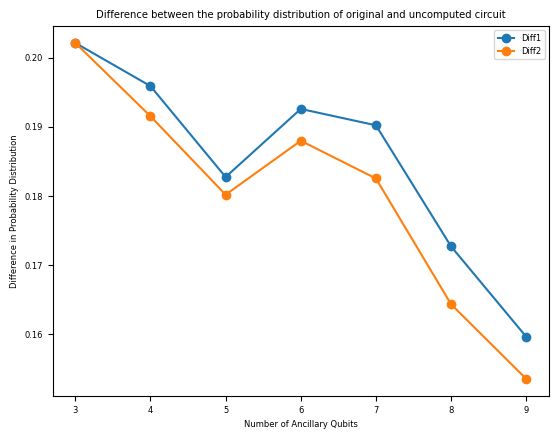

In [134]:
plt.plot(x_axis, ex_comp_avg, marker='o', linestyle='-', label='Diff1')
plt.plot(x_axis, ex_uncomp_avg, marker='o', linestyle='-', label='Diff2')
# plt.setp(lines)
plt.title(f'Difference between the probability distribution of original and uncomputed circuit')
plt.xlabel('Number of Ancillary Qubits')
plt.ylabel('Difference in Probability Distribution')
plt.legend()
plt.show()

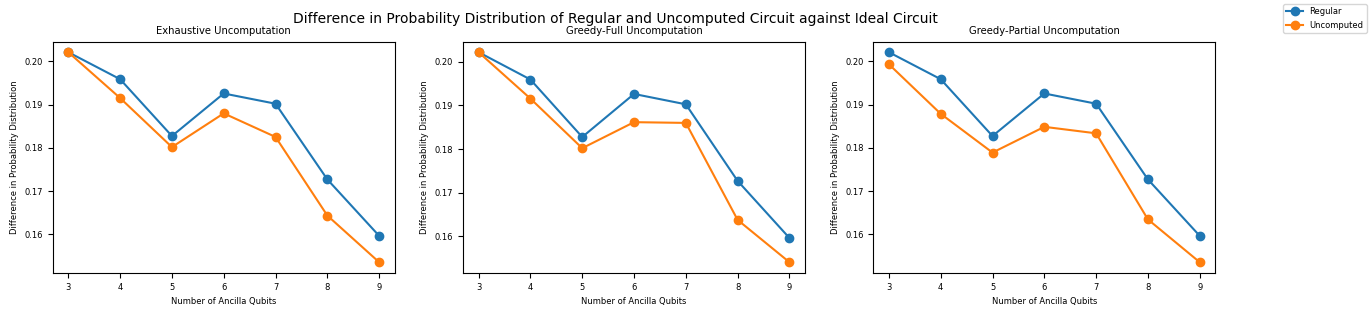

In [135]:
plt.rcParams['font.size'] = 6
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,3))

ax1.plot(x_axis, ex_comp_avg, marker='o', linestyle='-', label='Regular')
ax1.plot(x_axis, ex_uncomp_avg, marker='o', linestyle='-', label='Uncomputed')
ax1.set_title('Exhaustive Uncomputation')
ax1.set_xlabel('Number of Ancilla Qubits')
ax1.set_ylabel('Difference in Probability Distribution')

ax2.plot(x_axis, gf_comp_avg, marker='o', linestyle='-')
ax2.plot(x_axis, gf_uncomp_avg, marker='o', linestyle='-')
ax2.set_title('Greedy-Full Uncomputation')
ax2.set_xlabel('Number of Ancilla Qubits')
ax2.set_ylabel('Difference in Probability Distribution')

ax3.plot(x_axis, gp_comp_avg, marker='o', linestyle='-')
ax3.plot(x_axis, gp_uncomp_avg, marker='o', linestyle='-')
ax3.set_title('Greedy-Partial Uncomputation')
ax3.set_xlabel('Number of Ancilla Qubits')
ax3.set_ylabel('Difference in Probability Distribution')

fig.suptitle('Difference in Probability Distribution of Regular and Uncomputed Circuit against Ideal Circuit', fontsize=10)
fig.legend()

plt.show()
